In [ ]:
import os
import glob
import time
import random

import numpy as np
import scipy.io

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.amp import GradScaler, autocast

import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights

from PIL import Image

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    accuracy_score,
    precision_score, recall_score, f1_score,
    classification_report, confusion_matrix,
    top_k_accuracy_score,
    roc_curve, auc
)

=------------------------------------- Exploratory Data analysis -------------------------------------=

In this section I:
- load the image paths and labels from "imagelabels.mat",
- verify that the number of images matches the number of labels,
- inspect class distribution (how many images per class),
- visualize random samples from different classes,
- analyze image size variability (width/height).

This helps identify potential issues such as class imbalance and inconsistent image resolutions, which influence preprocessing, augmentation, and training strategy.

In [2]:
image_paths = sorted(glob.glob("jpg/*.jpg"))
mat = scipy.io.loadmat("imagelabels.mat")
labels = mat["labels"][0]

print(f'Number of labels: {len(labels)}')
print(f'Number of images: {len(image_paths)}')

print("\nUnique labels (classes):")
print(np.unique(labels))

Number of labels: 8189
Number of images: 8189

Unique labels (classes):
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102]


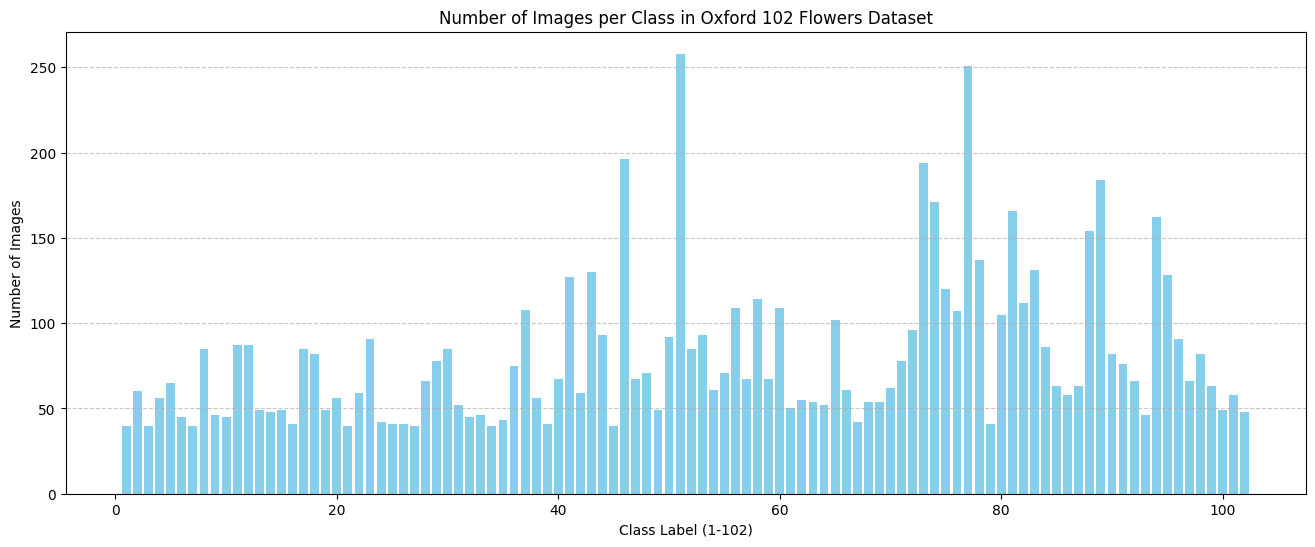

On average 80.3 images per class (min: 40, max: 258)


In [96]:
unique, counts = np.unique(labels, return_counts=True)

plt.figure(figsize=(16, 6))
plt.bar(unique, counts, color='skyblue')
plt.title("Number of Images per Class in Oxford 102 Flowers Dataset")
plt.xlabel("Class Label (1-102)")
plt.ylabel("Number of Images")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

mean_count = np.mean(counts)
min_count = np.min(counts)
max_count = np.max(counts)

print(f"On average {mean_count:.1f} images per class (min: {min_count}, max: {max_count})")

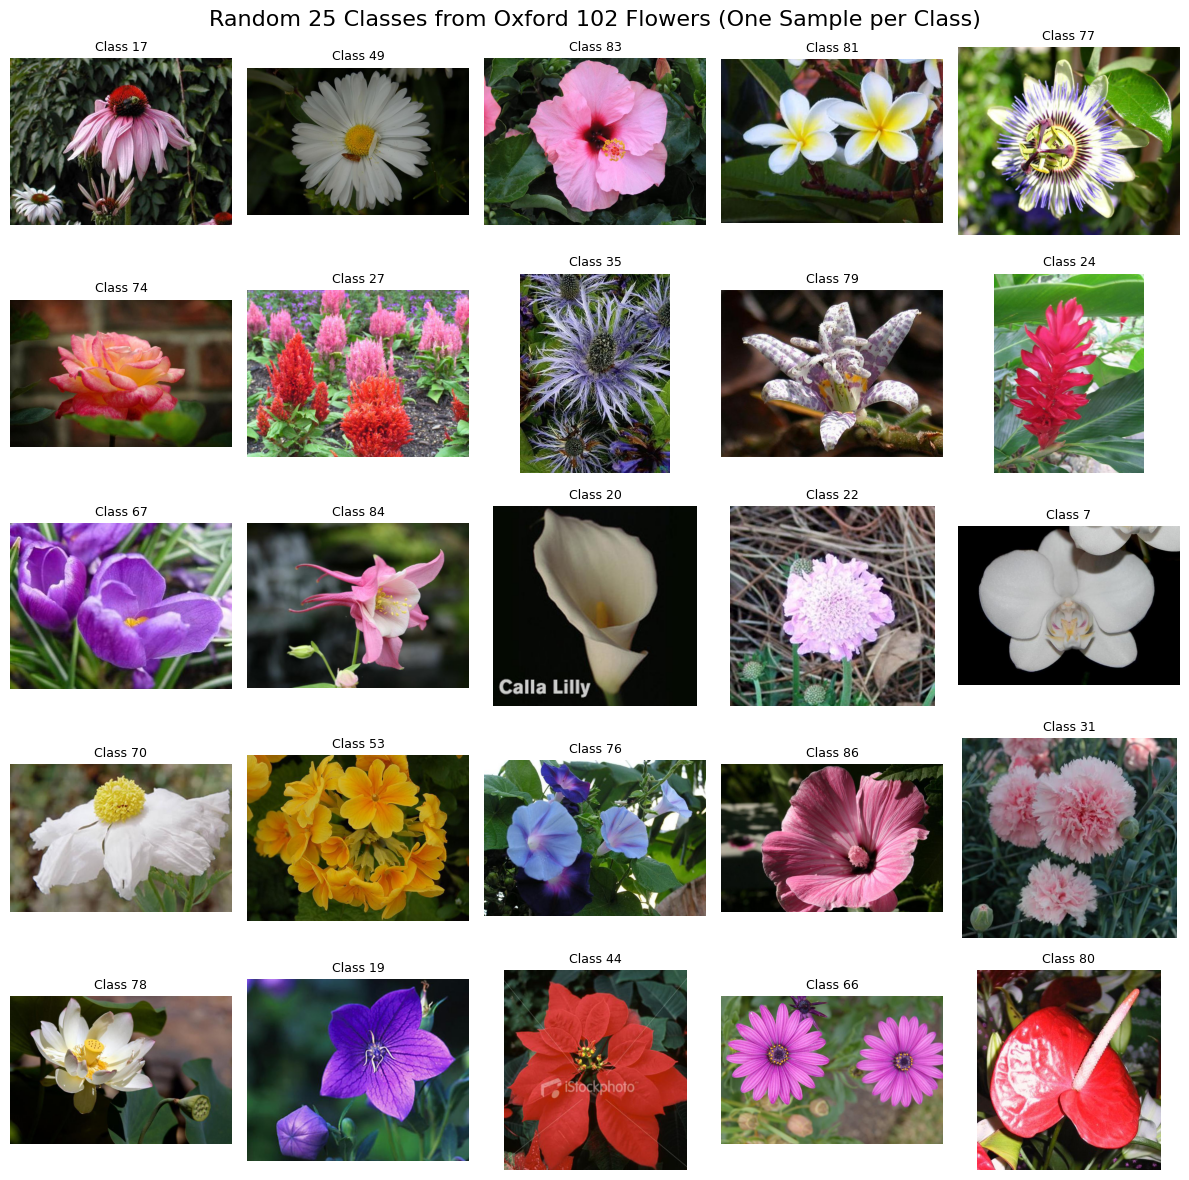

In [97]:
plt.figure(figsize=(12, 12))

sample_classes = random.sample(list(np.unique(labels)), 25)

sample_indices = [np.where(labels == c)[0][0] for c in sample_classes]

for i, idx in enumerate(sample_indices):
    img = Image.open(image_paths[idx])
    label = labels[idx]
    plt.subplot(5, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Class {label}", fontsize=9)
    plt.axis('off')

plt.suptitle("Random 25 Classes from Oxford 102 Flowers (One Sample per Class)", fontsize=16)
plt.tight_layout()
plt.show()

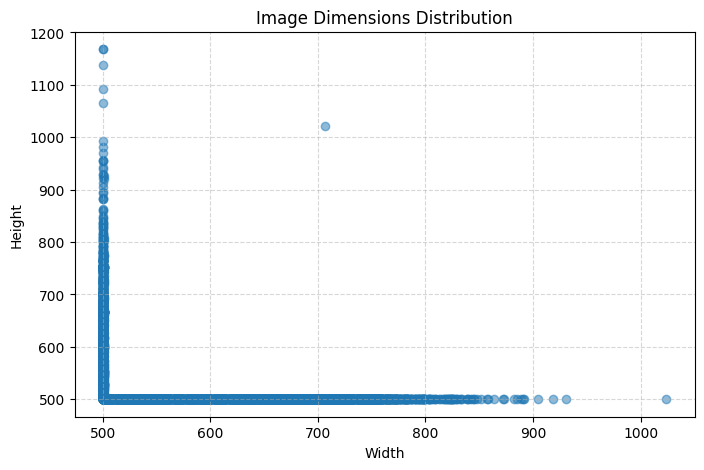

In [98]:
sizes = [Image.open(p).size for p in image_paths]
widths, heights = zip(*sizes)

plt.figure(figsize=(8, 5))
plt.scatter(widths, heights, alpha=0.5)
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Image Dimensions Distribution")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Results and Conclusions:

The Oxford Flowers 102 dataset contains 8189 images mapped to 102 classes, confirming consistency between image files and labels.

The class distribution is uneven, with the number of images per class ranging from 40 to 258.

While the imbalance is not extreme, it may still affect training dynamics and model generalization, especially for minority classes.

=------------------------------------- Dataset class / Preprocessing / Data split -------------------------------------=

In this section I:
- implement a custom Dataset for loading images and labels,
- convert labels from 1-102 to 0-101 (required for PyTorch classification),
- compute dataset-specific normalization statistics (mean/std) for models trained from scratch,
- apply ImageNet normalization for pretrained ResNet-50 to match the backbone's expected input distribution,
- define data augmentation for training and deterministic preprocessing for validation and testing,
- create a stratified train/validation/test split to preserve class proportions.

In [3]:
class FlowersDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        label = int(self.labels[idx] - 1)
        if self.transform:
            img = self.transform(img)
        return img, label

In [100]:
transform_for_stats = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

raw_dataset = FlowersDataset(image_paths, labels, transform=transform_for_stats)
loader = DataLoader(raw_dataset, batch_size=64, shuffle=False, num_workers=0)

mean = torch.zeros(3)
std = torch.zeros(3)
total_images = 0

for imgs, _ in loader:
    imgs = imgs.to('cpu')
    batch_samples = imgs.size(0)
    channels = imgs.size(1)
    imgs = imgs.view(batch_samples, channels, -1)
    mean += imgs.mean(2).sum(0)
    std += imgs.std(2).sum(0)
    total_images += batch_samples

mean /= total_images
std /= total_images

print("Mean:", mean)
print("Std:", std)


Mean: tensor([0.4355, 0.3777, 0.2880])
Std: tensor([0.2621, 0.2086, 0.2158])


In [4]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4355, 0.3777, 0.2880], std=[0.2621, 0.2086, 0.2158])
])

transform_eval = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4355, 0.3777, 0.2880], std=[0.2621, 0.2086, 0.2158])
])

transform_pretrained_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_pretrained_eval = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [5]:
all_indices = np.arange(len(image_paths))
train_idx, temp_idx = train_test_split(all_indices, test_size=0.3, stratify=labels, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=labels[temp_idx], random_state=42)

print(f"Total samples: {len(all_indices)}")
print(f"Training samples: {len(train_idx)}")
print(f"Validation samples: {len(val_idx)}")
print(f"Test samples: {len(test_idx)}")

Total samples: 8189
Training samples: 5732
Validation samples: 1228
Test samples: 1229


In [6]:
train_dataset = FlowersDataset([image_paths[i] for i in train_idx], [labels[i] for i in train_idx], transform=transform_train)
val_dataset = FlowersDataset([image_paths[i] for i in val_idx], [labels[i] for i in val_idx], transform=transform_eval)
test_dataset = FlowersDataset([image_paths[i] for i in test_idx], [labels[i] for i in test_idx], transform=transform_eval)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

train_pretrained_dataset = FlowersDataset([image_paths[i] for i in train_idx], [labels[i] for i in train_idx], transform=transform_pretrained_train)
val_pretrained_dataset = FlowersDataset([image_paths[i] for i in val_idx], [labels[i] for i in val_idx], transform=transform_pretrained_eval)
test_pretrained_dataset = FlowersDataset([image_paths[i] for i in test_idx], [labels[i] for i in test_idx], transform=transform_pretrained_eval)
train_pretrained_loader = DataLoader(train_pretrained_dataset, batch_size=32, shuffle=True, num_workers=0)
val_pretrained_loader   = DataLoader(val_pretrained_dataset, batch_size=32, shuffle=False, num_workers=0)
test_pretrained_loader  = DataLoader(test_pretrained_dataset, batch_size=32, shuffle=False, num_workers=0)

Results and Conclusions:

Computed dataset-specific normalization statistics:
- Mean: [0.4355, 0.3777, 0.2880]
- Std:  [0.2621, 0.2086, 0.2158]

These values were used to normalize inputs for models trained from scratch. For pretrained ResNet-50, ImageNet normalization was applied to ensure compatibility with the pretrained backbone.

The dataset was split using stratified sampling into:
- Training: 5732 samples (~70%)
- Validation: 1228 samples (~15%)
- Test: 1229 samples (~15%)

Stratification ensures that class proportions are preserved across all splits, providing a reliable evaluation of model performance.

=------------------------------------- Training, evaluation and experiment utilities -------------------------------------=

In this section I implement a reusable training and evaluation pipeline:
- 'train_model(...)' - training loop with optional mixed precision (AMP), learning-rate scheduler support, early stopping based on validation loss and automatic saving of the best checkpoint.
- 'plot_training_curves(...)' - visualization of loss/accuracy for monitoring convergence and overfitting.
- 'test_model(...)' - test-time evaluation including:
  - Top-1 accuracy and optional Top-k accuracy,
  - macro/micro Precision/Recall/F1,
  - confusion matrix visualization,
  - inference time per sample and basic model "footprint" (params + file size).
- 'cross_validation(...)' - repeated stratified evaluation (Monte Carlo style) to estimate metric stability across runs.
- 'plot_confusion_only_errors(...)' - focuses the confusion matrix on misclassified classes for easier error analysis.

Finally, the notebook automatically selects GPU (CUDA) if available, otherwise falls back to CPU.

In [7]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs, patience, save_path, scheduler=None, logs=True):
    start_time = time.time()

    if device.type == "cuda":
        use_amp = True
        scaler = GradScaler(device="cuda")
    else:
        use_amp = False
        scaler = None

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    patience_counter = 0
    best_epoch = 0
    best_metrics = {"train_loss": None, "train_acc": None, "val_loss": float('inf'), "val_acc": None}

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", leave=False)
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            if use_amp:
                with autocast(device_type="cuda"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            loop.set_postfix(loss=loss.item())

        avg_train_loss = train_loss / total
        train_accuracy = correct / total
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        avg_val_loss = val_loss / val_total
        val_accuracy = val_correct / val_total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        if avg_val_loss < best_metrics['val_loss']:
            best_epoch = epoch + 1
            best_metrics = {
            "train_loss": avg_train_loss,
            "train_acc": train_accuracy,
            "val_loss": avg_val_loss,
            "val_acc": val_accuracy
            }
            patience_counter = 0
            torch.save(model.state_dict(), save_path)
        else:
            patience_counter += 1

        if logs:
            print(f"Epoch {epoch + 1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f} | Valid Loss: {avg_val_loss:.4f} | Valid Acc: {val_accuracy:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f} | Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print(f"Training interrupted in epoch {epoch + 1}. No improvement for {patience} epochs.")
            break

        if scheduler is not None:
            scheduler.step()

    
    total_time = time.time() - start_time

    model.load_state_dict(torch.load(save_path, map_location=device, weights_only=True))
    model.to(device)

    print(f"Training complete in {total_time} seconds ({total_time/60:.4f} minutes)")
    print(f"Best model from epoch {best_epoch}: Train Loss: {best_metrics['train_loss']:.4f} | Train Acc: {best_metrics['train_acc']:.4f} | Valid Loss: {best_metrics['val_loss']:.4f} | Valid Acc: {best_metrics['val_acc']:.4f}")

    return model, total_time, train_losses, val_losses, train_accuracies, val_accuracies

In [8]:
def plot_training_curves(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss", linewidth=2)
    plt.plot(epochs, val_losses, label="Validation Loss", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label="Train Accuracy", linewidth=2)
    plt.plot(epochs, val_accs, label="Validation Accuracy", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [9]:
def test_model(model, test_loader, device, class_names, model_path, topk=False, k=5, plots=True, plot_numbers=True, raport=True):
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []
    all_outputs = []
    inference_times = []
    topk_acc = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            start_time = time.time()
            outputs = model(inputs)
            end_time = time.time()

            inference_times.append((end_time - start_time) / inputs.size(0))

            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_outputs.extend(outputs.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_outputs = np.array(all_outputs)

    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy (Top-1): {accuracy:.4f}")

    if topk:
        topk_acc = top_k_accuracy_score(all_labels, all_outputs, k=k)
        print(f"Test Accuracy (Top-{k}): {topk_acc:.4f}")

    avg_inf_time = np.mean(inference_times)
    print(f"Average inference time: {avg_inf_time * 1000:.2f} ms / sample")

    if raport:
        num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Number of model parameters: {num_params:,}")

        model_size_mb = os.path.getsize(model_path) / (1024 ** 2)
        print(f"Model size: {model_size_mb:.2f} MB\n")

    precision_macro = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall_macro    = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1_macro        = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    precision_micro = precision_score(all_labels, all_preds, average='micro', zero_division=0)
    recall_micro    = recall_score(all_labels, all_preds, average='micro', zero_division=0)
    f1_micro        = f1_score(all_labels, all_preds, average='micro', zero_division=0)

    print("Macro averages:")
    print(f"Precision: {precision_macro:.4f}")
    print(f"Recall:    {recall_macro:.4f}")
    print(f"F1-score:  {f1_macro:.4f}")

    print("Micro averages:")
    print(f"Precision: {precision_micro:.4f}")
    print(f"Recall:    {recall_micro:.4f}")
    print(f"F1-score:  {f1_micro:.4f}")

    if raport:
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

    cm = confusion_matrix(all_labels, all_preds)

    if plots:
        plt.figure(figsize=(12, 10))
        ax = sns.heatmap(cm, annot=plot_numbers, fmt='d' if plot_numbers else '', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        ax.set_aspect('equal')
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.xticks(fontsize=6)
        plt.yticks(fontsize=6)
        plt.tight_layout()
        plt.show()

        n_classes = len(class_names)

        y_true_bin = label_binarize(all_labels, classes=list(range(n_classes)))

        fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), all_outputs.ravel())
        auc_micro = auc(fpr_micro, tpr_micro)

        fpr_macro = {}
        tpr_macro = {}

        for i in range(n_classes):
            fpr_macro[i], tpr_macro[i], _ = roc_curve(y_true_bin[:, i], all_outputs[:, i])

        all_fpr = np.unique(np.concatenate([fpr_macro[i] for i in range(n_classes)]))

        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr_macro[i], tpr_macro[i])

        mean_tpr /= n_classes
        auc_macro_value = auc(all_fpr, mean_tpr)

        plt.figure(figsize=(5, 5))
        plt.plot(fpr_micro, tpr_micro, label=f"Micro-average ROC (AUC = {auc_micro:.4f})")
        plt.plot(all_fpr, mean_tpr, label=f"Macro-average ROC (AUC = {auc_macro_value:.4f})")
        plt.plot([0, 1], [0, 1], "--", color="gray")

        plt.title("ROC Curve (Micro & Macro)")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return accuracy, topk_acc, avg_inf_time, precision_macro, recall_macro, f1_macro, precision_micro, recall_micro, f1_micro, cm

In [10]:
def plot_confusion_only_errors(cm, class_names, plot_numbers=True):
    cm = np.array(cm)
    wrong_rows = np.where((cm - np.diag(np.diag(cm))).sum(axis=1) > 0)[0]
    wrong_cols = np.where((cm - np.diag(np.diag(cm))).sum(axis=0) > 0)[0]

    wrong_classes = np.unique(np.concatenate([wrong_rows, wrong_cols]))
    cm_filtered = cm[np.ix_(wrong_classes, wrong_classes)]
    names_filtered = [class_names[i] for i in wrong_classes]

    plt.figure(figsize=(12, 10))
    ax = sns.heatmap(cm_filtered, annot=plot_numbers, fmt='d' if plot_numbers else '', cmap="Blues", xticklabels=names_filtered, yticklabels=names_filtered)
    ax.set_aspect('equal')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.tight_layout()
    plt.show()

In [11]:
def cross_validation(image_paths, labels, model_name, model_class, class_names, criterion_fn, optimizer_fn, device, transform_train, transform_eval, kfold=10, batch_size=32, num_epochs=100, patience=8, topk=False, k=5, scheduler_fn=None, plot_numbers=True):
    print(f"\n===== CROSS VALIDATION START ({kfold} folds) for {model_name} =====")

    X = np.arange(len(image_paths))
    y = np.array(labels) - 1

    acc_list = []
    topk_list = []
    macro_p_list = []
    macro_r_list = []
    macro_f1_list = []
    micro_p_list = []
    micro_r_list = []
    micro_f1_list = []
    train_times = []
    infer_times = []

    total_cm = np.zeros((len(class_names), len(class_names)), dtype=int)
    best_model_path = f"best_{model_name}_cross_validation.pth"

    for fold in range(kfold):
        train_idx, temp_idx = train_test_split(X, test_size=0.30, stratify=y, random_state=42 + fold)
        val_idx, test_idx = train_test_split(temp_idx, test_size=0.50, stratify=y[temp_idx], random_state=42 + fold)

        train_ds = FlowersDataset([image_paths[i] for i in train_idx], [labels[i] for i in train_idx], transform=transform_train)
        val_ds = FlowersDataset([image_paths[i] for i in val_idx], [labels[i] for i in val_idx], transform=transform_eval)
        test_ds = FlowersDataset([image_paths[i] for i in test_idx], [labels[i] for i in test_idx], transform=transform_eval)

        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)
        test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)

        model = model_class().to(device)
        criterion = criterion_fn()
        optimizer = optimizer_fn(model)
        scheduler = scheduler_fn(optimizer) if scheduler_fn is not None else None

        print(f"\n--- FOLD {fold+1} Results ---")
        model, total_time, _, _, _, _ = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs, patience, best_model_path, scheduler=scheduler, logs=None)
        train_times.append(total_time)

        accuracy, topk_acc, avg_inf_time, precision_macro, recall_macro, f1_macro, precision_micro, recall_micro, f1_micro, cm = test_model(model, test_loader, device, class_names, best_model_path, topk=topk, k=k, plots=False, plot_numbers=False, raport=False)

        infer_times.append(avg_inf_time)
        acc_list.append(accuracy)
        topk_list.append(topk_acc)

        macro_p_list.append(precision_macro)
        macro_r_list.append(recall_macro)
        macro_f1_list.append(f1_macro)
        micro_p_list.append(precision_micro)
        micro_r_list.append(recall_micro)
        micro_f1_list.append(f1_micro)

        total_cm += cm

    print("\n\n\n===== CROSS-VALIDATION METRICS SUMMARY =====")
    print(f"Mean Top-1 Accuracy: {np.mean(acc_list):.4f} +/- {np.std(acc_list):.4f}")
    if topk:
        print(f"Mean Top-{k} Accuracy: {np.mean(topk_list):.4f} +/- {np.std(topk_list):.4f}")
    print(f"Mean Train Time: {np.mean(train_times):.2f} seconds ({np.mean(train_times)/60:.2f} minutes)")
    print(f"Mean Inference Time: {np.mean(infer_times)*1000:.2f} milliseconds/sample")

    print(f"\nMacro Averages:")
    print(f"Precision (Macro): {np.mean(macro_p_list):.4f}")
    print(f"Recall    (Macro): {np.mean(macro_r_list):.4f}")
    print(f"F1-Score  (Macro): {np.mean(macro_f1_list):.4f}")

    print(f"\nMicro Averages:")
    print(f"Precision (Micro): {np.mean(micro_p_list):.4f}")
    print(f"Recall    (Micro): {np.mean(micro_r_list):.4f}")
    print(f"F1-Score  (Micro): {np.mean(micro_f1_list):.4f}")

    plt.figure(figsize=(10,5))
    plt.bar(range(1, kfold+1), acc_list)
    plt.title(f"{model_name}: Accuracy per Fold")
    plt.xlabel("Fold")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 10))
    ax = sns.heatmap(cm, annot=plot_numbers, fmt='d' if plot_numbers else '', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    ax.set_aspect('equal')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.tight_layout()
    plt.show()

    return total_cm

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("==== HARDWARE DATA ====")
print("Selected device:", device)

if torch.cuda.is_available():
    print("\n==== GPU INFORMATION ====")
    print("CUDA available:", torch.cuda.is_available())
    print("Number of GPUs:", torch.cuda.device_count())
    print("Current GPU:", torch.cuda.current_device())
    print("GPU name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("CUDA unavailable - CPU used")

==== HARDWARE DATA ====
Selected device: cuda

==== GPU INFORMATION ====
CUDA available: True
Number of GPUs: 1
Current GPU: 0
GPU name: NVIDIA GeForce RTX 4070 SUPER


Results and Conclusions:

All experiments were executed on a local machine with the following hardware configuration:
- Device: CUDA (GPU acceleration enabled)
- GPU: NVIDIA GeForce RTX 4070 SUPER
- Number of GPUs: 1

GPU acceleration was used to speed up training and enable mixed precision (AMP), significantly reducing training time compared to CPU execution.

=------------------------------------- ResNet-50 Full Pretrained -------------------------------------=

In this section I train and evaluate ResNet-50 under transfer learning settings.

A reusable function is implemented to initialize ResNet-50 with different training strategies:
- Backbone: ResNet-50 from 'torchvision'
- Pretraining: optional ImageNet weights ('pretrained=True/False')
- Classifier head: final 'fc' layer replaced with 'Linear(..., 102)'
- Training modes:
  - 'fine_tune=False': freeze the backbone and train only the classification head
  - 'fine_tune=True': fine-tune the entire network (backbone + head)

This design allows direct comparison between different transfer learning strategies.

Instead of strict k-fold cross-validation, a Monte Carlo–style evaluation using repeated stratified train/validation/test splits was employed. This choice preserves a dedicated validation set for early stopping and avoids extremely small test sets, which would occur for minority classes with limited samples.

The following configuration was used for all experiments reported below:
- Pretrained weights: ImageNet ('pretrained=True')
- Fine-tuning: full network fine-tuning ('fine_tune=True')
- Loss: Cross-Entropy with label smoothing (0.1)
- Optimizer: Adam (learning rate = 1e-4)
- Early stopping: patience = 8 (based on validation loss)
- Metrics: Top-1 and Top-5 accuracy, macro/micro Precision, Recall and F1-score
- Evaluation: repeated stratified train/validation/test splits (10 runs) to assess performance stability

In [ ]:
def resnet50_model(num_classes, fine_tune, pretrained):
    weights = ResNet50_Weights.IMAGENET1K_V1 if pretrained else None
    model = resnet50(weights=weights)

    model.fc = nn.Linear(model.fc.in_features, num_classes)

    if fine_tune:
        for param in model.parameters():
            param.requires_grad = True
    else:
        for param in model.parameters():
            param.requires_grad = False
        for param in model.fc.parameters():
            param.requires_grad = True

    return model

In [ ]:
model = resnet50_model(num_classes=102, fine_tune=True, pretrained=True).to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

model, total_time_full_pretrained, train_losses_full_pretrained, val_losses_full_pretrained, train_accs_full_pretrained, val_accs_full_pretrained = train_model(
    model=model,
    train_loader=train_pretrained_loader,
    val_loader=val_pretrained_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=100,
    patience=8,
    save_path="best_resnet50_full_pretrained.pth",
    scheduler=None,
    logs=True
)

Epoch 1/100 | Train Loss: 2.4373 | Train Acc: 0.6038 | Valid Loss: 1.2742 | Valid Acc: 0.9072 | LR: 0.000100 | Patience: 0/8


Epoch 2/100 | Train Loss: 1.1131 | Train Acc: 0.9412 | Valid Loss: 1.0649 | Valid Acc: 0.9422 | LR: 0.000100 | Patience: 0/8


Epoch 3/100 | Train Loss: 0.9565 | Train Acc: 0.9775 | Valid Loss: 1.0054 | Valid Acc: 0.9585 | LR: 0.000100 | Patience: 0/8


Epoch 4/100 | Train Loss: 0.9112 | Train Acc: 0.9864 | Valid Loss: 0.9749 | Valid Acc: 0.9674 | LR: 0.000100 | Patience: 0/8


Epoch 5/100 | Train Loss: 0.8914 | Train Acc: 0.9899 | Valid Loss: 0.9491 | Valid Acc: 0.9715 | LR: 0.000100 | Patience: 0/8


Epoch 6/100 | Train Loss: 0.8629 | Train Acc: 0.9946 | Valid Loss: 0.9321 | Valid Acc: 0.9756 | LR: 0.000100 | Patience: 0/8


Epoch 7/100 | Train Loss: 0.8603 | Train Acc: 0.9946 | Valid Loss: 0.9259 | Valid Acc: 0.9723 | LR: 0.000100 | Patience: 0/8


Epoch 8/100 | Train Loss: 0.8590 | Train Acc: 0.9956 | Valid Loss: 0.9489 | Valid Acc: 0.9707 | LR: 0.000100 | Patience: 1/8


Epoch 9/100 | Train Loss: 0.8490 | Train Acc: 0.9963 | Valid Loss: 0.9132 | Valid Acc: 0.9788 | LR: 0.000100 | Patience: 0/8


Epoch 10/100 | Train Loss: 0.8598 | Train Acc: 0.9934 | Valid Loss: 0.9660 | Valid Acc: 0.9617 | LR: 0.000100 | Patience: 1/8


Epoch 11/100 | Train Loss: 0.8465 | Train Acc: 0.9955 | Valid Loss: 0.9074 | Valid Acc: 0.9772 | LR: 0.000100 | Patience: 0/8


Epoch 12/100 | Train Loss: 0.8369 | Train Acc: 0.9969 | Valid Loss: 0.9034 | Valid Acc: 0.9723 | LR: 0.000100 | Patience: 0/8


Epoch 13/100 | Train Loss: 0.8275 | Train Acc: 0.9983 | Valid Loss: 0.8998 | Valid Acc: 0.9780 | LR: 0.000100 | Patience: 0/8


Epoch 14/100 | Train Loss: 0.8235 | Train Acc: 0.9986 | Valid Loss: 0.8981 | Valid Acc: 0.9756 | LR: 0.000100 | Patience: 0/8


Epoch 15/100 | Train Loss: 0.8149 | Train Acc: 0.9986 | Valid Loss: 0.8926 | Valid Acc: 0.9780 | LR: 0.000100 | Patience: 0/8


Epoch 16/100 | Train Loss: 0.8299 | Train Acc: 0.9965 | Valid Loss: 0.8879 | Valid Acc: 0.9796 | LR: 0.000100 | Patience: 0/8


Epoch 17/100 | Train Loss: 0.8222 | Train Acc: 0.9983 | Valid Loss: 0.9181 | Valid Acc: 0.9682 | LR: 0.000100 | Patience: 1/8


Epoch 18/100 | Train Loss: 0.8402 | Train Acc: 0.9948 | Valid Loss: 0.9167 | Valid Acc: 0.9674 | LR: 0.000100 | Patience: 2/8


Epoch 19/100 | Train Loss: 0.8457 | Train Acc: 0.9925 | Valid Loss: 0.9468 | Valid Acc: 0.9593 | LR: 0.000100 | Patience: 3/8


Epoch 20/100 | Train Loss: 0.8302 | Train Acc: 0.9958 | Valid Loss: 0.8965 | Valid Acc: 0.9772 | LR: 0.000100 | Patience: 4/8


Epoch 21/100 | Train Loss: 0.8306 | Train Acc: 0.9962 | Valid Loss: 0.9195 | Valid Acc: 0.9674 | LR: 0.000100 | Patience: 5/8


Epoch 22/100 | Train Loss: 0.8275 | Train Acc: 0.9960 | Valid Loss: 0.8957 | Valid Acc: 0.9731 | LR: 0.000100 | Patience: 6/8


Epoch 23/100 | Train Loss: 0.8210 | Train Acc: 0.9965 | Valid Loss: 0.8950 | Valid Acc: 0.9748 | LR: 0.000100 | Patience: 7/8


Epoch 24/100 | Train Loss: 0.8174 | Train Acc: 0.9977 | Valid Loss: 0.8947 | Valid Acc: 0.9772 | LR: 0.000100 | Patience: 8/8
Training interrupted in epoch 24. No improvement for 8 epochs.
Training complete in 1057.3009462356567 seconds (17.6217 minutes)
Best model from epoch 16: Train Loss: 0.8299 | Train Acc: 0.9965 | Valid Loss: 0.8879 | Valid Acc: 0.9796


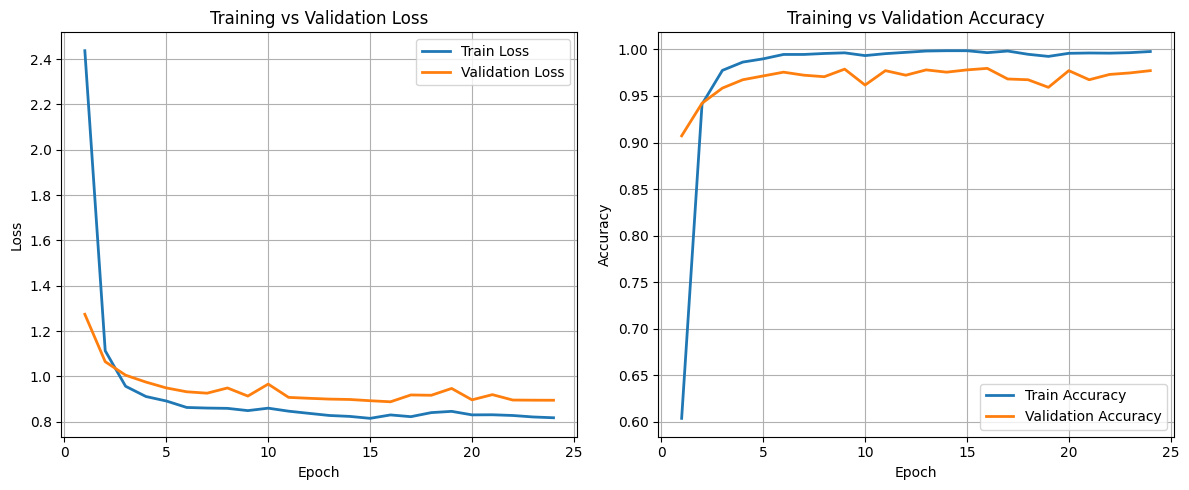

In [38]:
plot_training_curves(train_losses_full_pretrained, val_losses_full_pretrained, train_accs_full_pretrained, val_accs_full_pretrained)

Test Accuracy (Top-1): 0.9715
Test Accuracy (Top-5): 0.9959
Average inference time: 0.13 ms / sample
Number of model parameters: 23,717,030
Model size: 90.78 MB

Macro averages:
Precision: 0.9726
Recall:    0.9682
F1-score:  0.9685
Micro averages:
Precision: 0.9715
Recall:    0.9715
F1-score:  0.9715

Classification Report:
              precision    recall  f1-score   support

         C_0       1.00      1.00      1.00         6
         C_1       1.00      1.00      1.00         9
         C_2       0.75      1.00      0.86         6
         C_3       0.86      0.75      0.80         8
         C_4       1.00      1.00      1.00         9
         C_5       0.86      1.00      0.92         6
         C_6       0.86      1.00      0.92         6
         C_7       1.00      1.00      1.00        13
         C_8       1.00      0.86      0.92         7
         C_9       1.00      1.00      1.00         6
        C_10       0.92      0.92      0.92        13
        C_11       0.93  

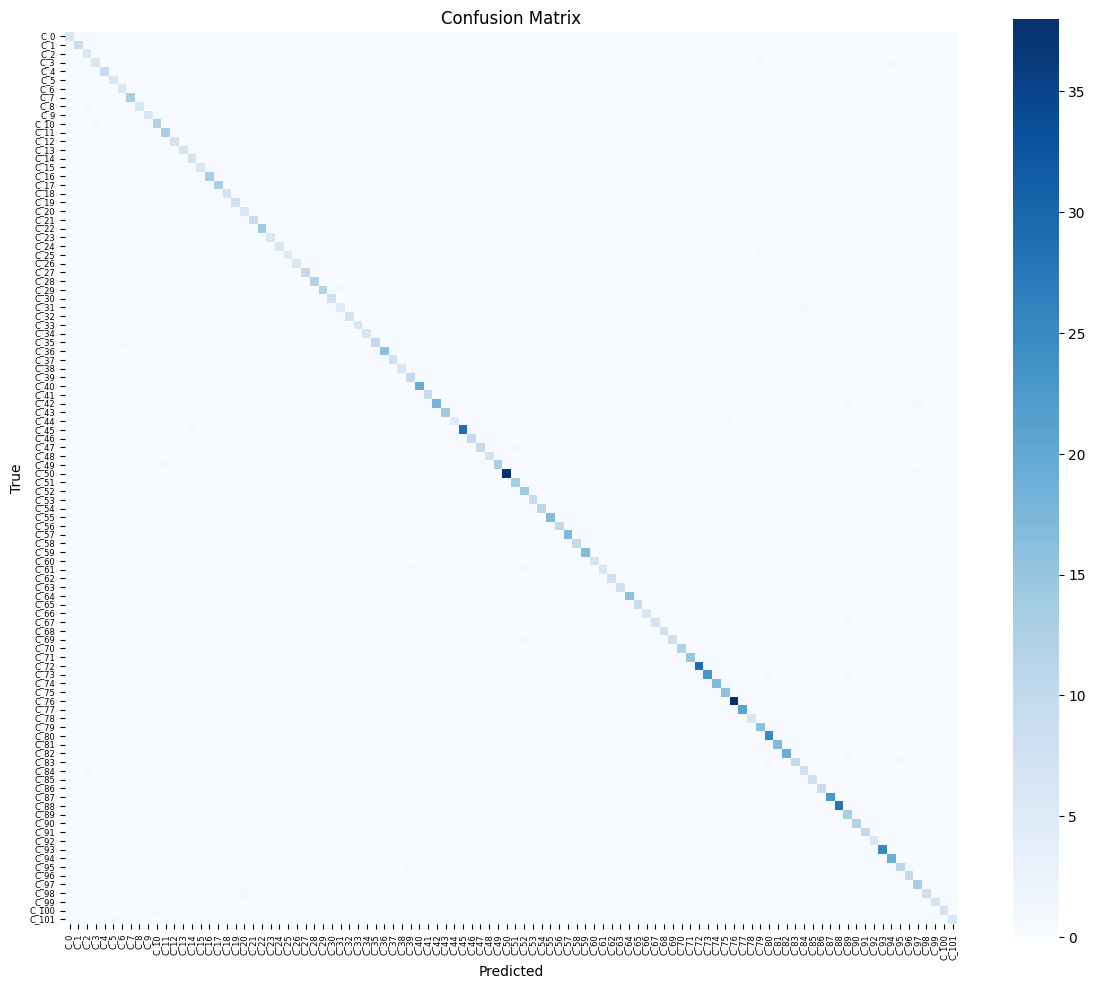

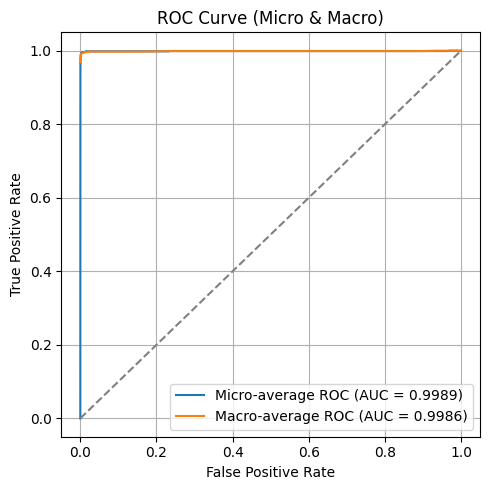

In [ ]:
accuracy_full_pretrained, topk_acc_full_pretrained, avg_inf_time_full_pretrained, precision_macro_full_pretrained, recall_macro_full_pretrained, f1_macro_full_pretrained, precision_micro_full_pretrained, recall_micro_full_pretrained, f1_micro_full_pretrained, cm = test_model(
    model=model,
    test_loader=test_pretrained_loader,
    device=device,
    class_names=[f"C_{i}" for i in range(102)],
    model_path="best_resnet50_full_pretrained.pth",
    topk=True,
    k=5,
    plots=True,
    plot_numbers=False,
    raport=True
)

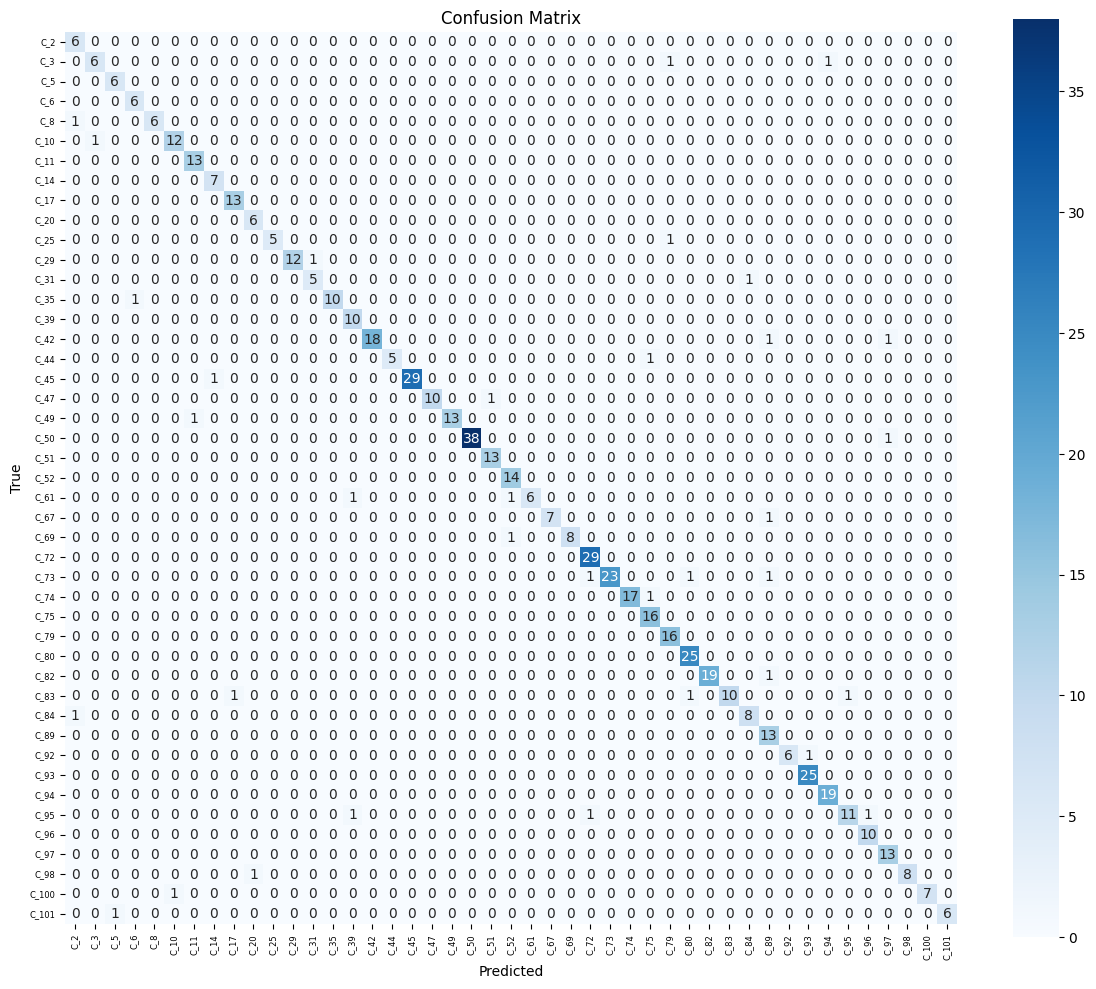

In [ ]:
plot_confusion_only_errors(cm, [f"C_{i}" for i in range(102)], plot_numbers=True)


===== CROSS VALIDATION START (10 folds) for ResNet-50 =====

--- FOLD 1 Results ---


Training interrupted in epoch 40. No improvement for 8 epochs.
Training complete in 2668.161657810211 seconds (44.4694 minutes)
Best model from epoch 32: Train Loss: 0.8144 | Train Acc: 0.9977 | Valid Loss: 0.8617 | Valid Acc: 0.9821
Test Accuracy (Top-1): 0.9715
Test Accuracy (Top-5): 0.9943
Average inference time: 0.26 ms / sample
Macro averages:
Precision: 0.9741
Recall:    0.9694
F1-score:  0.9696
Micro averages:
Precision: 0.9715
Recall:    0.9715
F1-score:  0.9715

--- FOLD 2 Results ---


Training interrupted in epoch 36. No improvement for 8 epochs.
Training complete in 2361.1676263809204 seconds (39.3528 minutes)
Best model from epoch 28: Train Loss: 0.8177 | Train Acc: 0.9962 | Valid Loss: 0.8796 | Valid Acc: 0.9788
Test Accuracy (Top-1): 0.9756
Test Accuracy (Top-5): 0.9984
Average inference time: 0.25 ms / sample
Macro averages:
Precision: 0.9778
Recall:    0.9744
F1-score:  0.9742
Micro averages:
Precision: 0.9756
Recall:    0.9756
F1-score:  0.9756

--- FOLD 3 Results ---


Training interrupted in epoch 27. No improvement for 8 epochs.
Training complete in 1773.2040843963623 seconds (29.5534 minutes)
Best model from epoch 19: Train Loss: 0.8221 | Train Acc: 0.9974 | Valid Loss: 0.8822 | Valid Acc: 0.9805
Test Accuracy (Top-1): 0.9756
Test Accuracy (Top-5): 0.9951
Average inference time: 0.25 ms / sample
Macro averages:
Precision: 0.9758
Recall:    0.9735
F1-score:  0.9725
Micro averages:
Precision: 0.9756
Recall:    0.9756
F1-score:  0.9756

--- FOLD 4 Results ---


Training interrupted in epoch 33. No improvement for 8 epochs.
Training complete in 2169.1117815971375 seconds (36.1519 minutes)
Best model from epoch 25: Train Loss: 0.8194 | Train Acc: 0.9965 | Valid Loss: 0.8901 | Valid Acc: 0.9748
Test Accuracy (Top-1): 0.9821
Test Accuracy (Top-5): 0.9976
Average inference time: 0.25 ms / sample
Macro averages:
Precision: 0.9817
Recall:    0.9786
F1-score:  0.9789
Micro averages:
Precision: 0.9821
Recall:    0.9821
F1-score:  0.9821

--- FOLD 5 Results ---


Training interrupted in epoch 33. No improvement for 8 epochs.
Training complete in 2168.815519094467 seconds (36.1469 minutes)
Best model from epoch 25: Train Loss: 0.7991 | Train Acc: 0.9998 | Valid Loss: 0.8729 | Valid Acc: 0.9862
Test Accuracy (Top-1): 0.9870
Test Accuracy (Top-5): 0.9984
Average inference time: 0.25 ms / sample
Macro averages:
Precision: 0.9881
Recall:    0.9830
F1-score:  0.9847
Micro averages:
Precision: 0.9870
Recall:    0.9870
F1-score:  0.9870

--- FOLD 6 Results ---


Training interrupted in epoch 26. No improvement for 8 epochs.
Training complete in 1707.0322942733765 seconds (28.4505 minutes)
Best model from epoch 18: Train Loss: 0.8115 | Train Acc: 0.9986 | Valid Loss: 0.8826 | Valid Acc: 0.9772
Test Accuracy (Top-1): 0.9691
Test Accuracy (Top-5): 0.9959
Average inference time: 0.25 ms / sample
Macro averages:
Precision: 0.9732
Recall:    0.9649
F1-score:  0.9672
Micro averages:
Precision: 0.9691
Recall:    0.9691
F1-score:  0.9691

--- FOLD 7 Results ---


Training interrupted in epoch 27. No improvement for 8 epochs.
Training complete in 1773.951008796692 seconds (29.5659 minutes)
Best model from epoch 19: Train Loss: 0.8189 | Train Acc: 0.9970 | Valid Loss: 0.8633 | Valid Acc: 0.9853
Test Accuracy (Top-1): 0.9764
Test Accuracy (Top-5): 0.9967
Average inference time: 0.25 ms / sample
Macro averages:
Precision: 0.9789
Recall:    0.9717
F1-score:  0.9739
Micro averages:
Precision: 0.9764
Recall:    0.9764
F1-score:  0.9764

--- FOLD 8 Results ---


Training interrupted in epoch 22. No improvement for 8 epochs.
Training complete in 1444.709809064865 seconds (24.0785 minutes)
Best model from epoch 14: Train Loss: 0.8288 | Train Acc: 0.9979 | Valid Loss: 0.8851 | Valid Acc: 0.9829
Test Accuracy (Top-1): 0.9731
Test Accuracy (Top-5): 0.9976
Average inference time: 0.25 ms / sample
Macro averages:
Precision: 0.9731
Recall:    0.9677
F1-score:  0.9685
Micro averages:
Precision: 0.9731
Recall:    0.9731
F1-score:  0.9731

--- FOLD 9 Results ---


Training interrupted in epoch 33. No improvement for 8 epochs.
Training complete in 2165.536618232727 seconds (36.0923 minutes)
Best model from epoch 25: Train Loss: 0.8031 | Train Acc: 0.9997 | Valid Loss: 0.8431 | Valid Acc: 0.9894
Test Accuracy (Top-1): 0.9797
Test Accuracy (Top-5): 0.9976
Average inference time: 0.25 ms / sample
Macro averages:
Precision: 0.9824
Recall:    0.9763
F1-score:  0.9784
Micro averages:
Precision: 0.9797
Recall:    0.9797
F1-score:  0.9797

--- FOLD 10 Results ---


Training interrupted in epoch 28. No improvement for 8 epochs.
Training complete in 1836.7720193862915 seconds (30.6129 minutes)
Best model from epoch 20: Train Loss: 0.8098 | Train Acc: 0.9988 | Valid Loss: 0.8737 | Valid Acc: 0.9829
Test Accuracy (Top-1): 0.9805
Test Accuracy (Top-5): 0.9976
Average inference time: 0.25 ms / sample
Macro averages:
Precision: 0.9812
Recall:    0.9775
F1-score:  0.9784
Micro averages:
Precision: 0.9805
Recall:    0.9805
F1-score:  0.9805



===== CROSS-VALIDATION METRICS SUMMARY =====
Mean Top-1 Accuracy: 0.9771 +/- 0.0051
Mean Top-5 Accuracy: 0.9969 +/- 0.0013
Mean Train Time: 2006.85 seconds (33.45 minutes)
Mean Inference Time: 0.25 milliseconds/sample

Macro Averages:
Precision (Macro): 0.9786
Recall    (Macro): 0.9737
F1-Score  (Macro): 0.9746

Micro Averages:
Precision (Micro): 0.9771
Recall    (Micro): 0.9771
F1-Score  (Micro): 0.9771


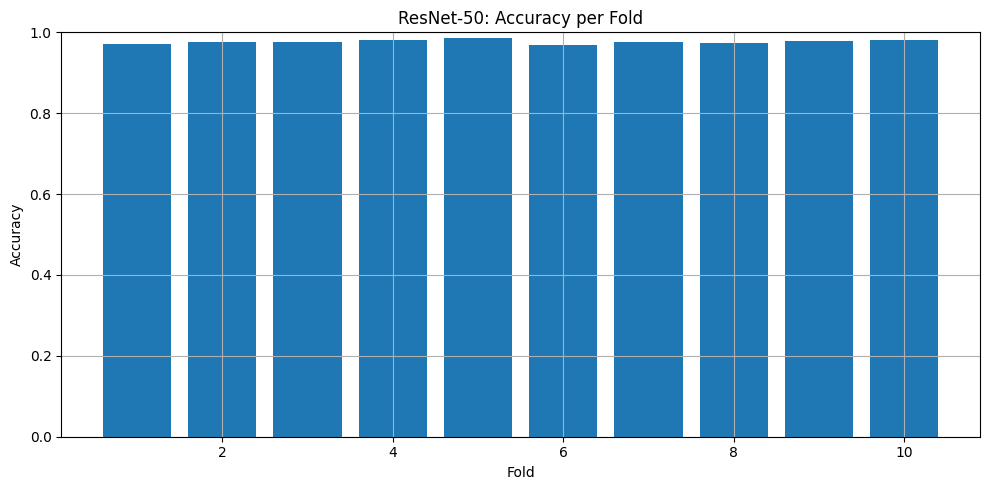

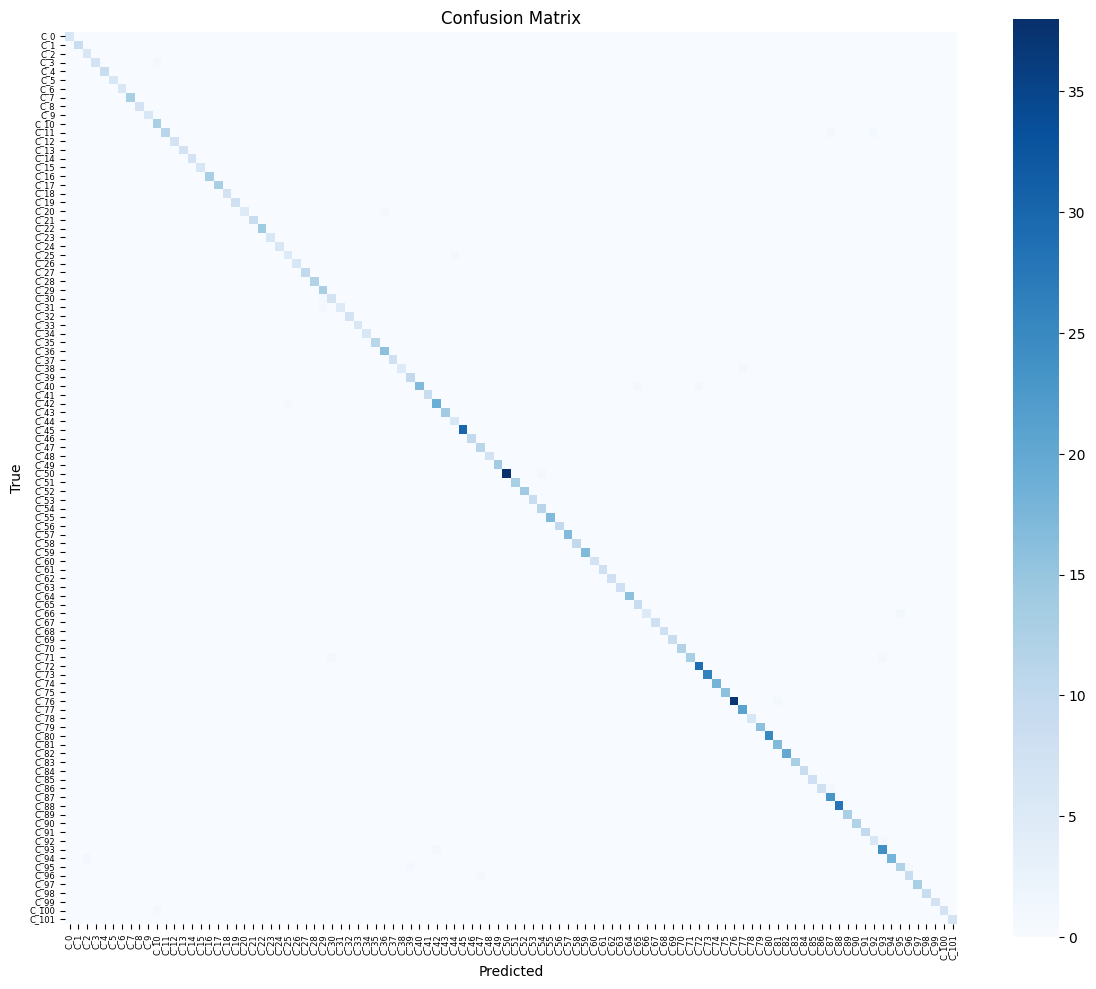

In [96]:
total_cm = cross_validation(
    image_paths=image_paths,
    labels=labels,
    model_name="ResNet-50",
    model_class=lambda: resnet50_model(num_classes=102, fine_tune=True, pretrained=True),
    class_names=[f"C_{i}" for i in range(102)], 
    criterion_fn=lambda: nn.CrossEntropyLoss(label_smoothing=0.1),
    optimizer_fn=lambda model: torch.optim.Adam(model.parameters(), lr=0.0001),
    device=device,
    transform_train=transform_pretrained_train,
    transform_eval=transform_pretrained_eval,
    kfold=10,
    batch_size=32,
    num_epochs=100,
    patience=8, 
    topk=True,
    k=5,
    scheduler_fn=None,
    plot_numbers=False
    )

Results and Conclusions:

The pretrained ResNet-50 with full fine-tuning achieved strong and stable performance on the Oxford Flowers 102 dataset.

Single split evaluation:
- Top-1 accuracy: 97.15%
- Top-5 accuracy: 99.59%
- Macro F1-score: 96.85%
- Micro F1-score: 97.15%
- Inference time: ~0.13 ms per image
- Model size: 90.78 MB (~23.7M parameters)

Training converged quickly, with validation accuracy exceeding 97% within the first few epochs. Early stopping halted training after 24 epochs, preventing overfitting. The gap between training and validation accuracy remained small, indicating good generalization. Loss and accuracy curves show smooth convergence without instability.

The confusion matrix is strongly diagonal, confirming that most predictions are correct. Misclassifications primarily occur between visually similar flower species which is expected in a fine-grained classification setting.

Both macro and micro ROC curves achieve near-perfect AUC values (~0.999), demonstrating consistent performance across all classes despite class imbalance.

Repeated stratified evaluation (10 runs) confirms the robustness of the model:
- Mean Top-1 accuracy: 97.71% std 0.51%
- Mean Top-5 accuracy: 99.69% std 0.13%
- Macro F1-score (mean): 97.46%
- Micro F1-score (mean): 97.71%
- Mean inference time: ~0.25 ms per image

Performance variance across runs is low, indicating that the model is stable and not sensitive to a particular train/validation/test split.

These results highlight the effectiveness of transfer learning with ResNet-50 for fine-grained image classification tasks. Pretrained features, combined with full fine-tuning and data augmentation, allow the model to achieve high accuracy while maintaining strong generalization.

=------------------------------------- LightResCNN -------------------------------------=

To provide a strong non-pretrained baseline, I designed and trained a lightweight CNN inspired by ResNet-style residual connections.

Architecture:
- ResidualBlock: two 3×3 convolutions with BatchNorm and ReLU, plus a skip connection (identity when channels match, 1×1 projection when they differ).
- The network progressively increases channel depth: 32 > 64 > 128 > 256 > 512 with max-pooling between stages.
- AdaptiveAvgPool2d(2×2) is used to reduce sensitivity to input spatial details while keeping a compact representation.
- The classifier uses a small MLP head with Dropout(0.4) for regularization.

This model is trained from scratch using dataset-specific normalization (computed earlier), which contrasts with transfer learning in ResNet-50.

In [13]:
class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch)
        )

        self.skip = nn.Identity()
        if in_ch != out_ch:
            self.skip = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_ch)
            )

    def forward(self, x):
        out = self.conv(x)
        out = out + self.skip(x)
        return torch.relu(out)

class LightResCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.features = nn.Sequential(
            ResidualBlock(3, 32),
            nn.MaxPool2d(2),

            ResidualBlock(32, 64),
            nn.MaxPool2d(2),

            ResidualBlock(64, 128),
            nn.MaxPool2d(2),

            ResidualBlock(128, 256),
            nn.MaxPool2d(2),

            ResidualBlock(256, 512),
            nn.AdaptiveAvgPool2d((2, 2))
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 2 * 2, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [87]:
model = LightResCNN(num_classes=102).to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

model, total_time_lightrescnn, train_losses_lightrescnn, val_losses_lightrescnn, train_accs_lightrescnn, val_accs_lightrescnn = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=100,
    patience=8,
    save_path="best_lightrescnn.pth",
    scheduler=None,
    logs=True
)

Epoch 1/100 | Train Loss: 4.1884 | Train Acc: 0.1017 | Valid Loss: 3.6530 | Valid Acc: 0.2011 | LR: 0.000100 | Patience: 0/8


Epoch 2/100 | Train Loss: 3.6760 | Train Acc: 0.1935 | Valid Loss: 3.3186 | Valid Acc: 0.2671 | LR: 0.000100 | Patience: 0/8


Epoch 3/100 | Train Loss: 3.4055 | Train Acc: 0.2601 | Valid Loss: 3.0617 | Valid Acc: 0.3282 | LR: 0.000100 | Patience: 0/8


Epoch 4/100 | Train Loss: 3.2029 | Train Acc: 0.3072 | Valid Loss: 2.9144 | Valid Acc: 0.3738 | LR: 0.000100 | Patience: 0/8


Epoch 5/100 | Train Loss: 3.0387 | Train Acc: 0.3458 | Valid Loss: 2.7260 | Valid Acc: 0.4153 | LR: 0.000100 | Patience: 0/8


Epoch 6/100 | Train Loss: 2.9002 | Train Acc: 0.3861 | Valid Loss: 2.6754 | Valid Acc: 0.4292 | LR: 0.000100 | Patience: 0/8


Epoch 7/100 | Train Loss: 2.7898 | Train Acc: 0.4082 | Valid Loss: 2.5728 | Valid Acc: 0.4666 | LR: 0.000100 | Patience: 0/8


Epoch 8/100 | Train Loss: 2.6804 | Train Acc: 0.4388 | Valid Loss: 2.4791 | Valid Acc: 0.4829 | LR: 0.000100 | Patience: 0/8


Epoch 9/100 | Train Loss: 2.5854 | Train Acc: 0.4684 | Valid Loss: 2.4023 | Valid Acc: 0.5138 | LR: 0.000100 | Patience: 0/8


Epoch 10/100 | Train Loss: 2.4914 | Train Acc: 0.4956 | Valid Loss: 2.3048 | Valid Acc: 0.5440 | LR: 0.000100 | Patience: 0/8


Epoch 11/100 | Train Loss: 2.3810 | Train Acc: 0.5300 | Valid Loss: 2.2738 | Valid Acc: 0.5513 | LR: 0.000100 | Patience: 0/8


Epoch 12/100 | Train Loss: 2.3421 | Train Acc: 0.5415 | Valid Loss: 2.1975 | Valid Acc: 0.5660 | LR: 0.000100 | Patience: 0/8


Epoch 13/100 | Train Loss: 2.2594 | Train Acc: 0.5710 | Valid Loss: 2.0936 | Valid Acc: 0.6230 | LR: 0.000100 | Patience: 0/8


Epoch 14/100 | Train Loss: 2.1931 | Train Acc: 0.5970 | Valid Loss: 2.0407 | Valid Acc: 0.6393 | LR: 0.000100 | Patience: 0/8


Epoch 15/100 | Train Loss: 2.1077 | Train Acc: 0.6235 | Valid Loss: 2.0392 | Valid Acc: 0.6287 | LR: 0.000100 | Patience: 0/8


Epoch 16/100 | Train Loss: 2.0625 | Train Acc: 0.6315 | Valid Loss: 1.9833 | Valid Acc: 0.6433 | LR: 0.000100 | Patience: 0/8


Epoch 17/100 | Train Loss: 1.9845 | Train Acc: 0.6640 | Valid Loss: 1.9499 | Valid Acc: 0.6645 | LR: 0.000100 | Patience: 0/8


Epoch 18/100 | Train Loss: 1.9426 | Train Acc: 0.6697 | Valid Loss: 1.9153 | Valid Acc: 0.6669 | LR: 0.000100 | Patience: 0/8


Epoch 19/100 | Train Loss: 1.8882 | Train Acc: 0.6954 | Valid Loss: 1.8537 | Valid Acc: 0.7077 | LR: 0.000100 | Patience: 0/8


Epoch 20/100 | Train Loss: 1.8439 | Train Acc: 0.7045 | Valid Loss: 1.8203 | Valid Acc: 0.7199 | LR: 0.000100 | Patience: 0/8


Epoch 21/100 | Train Loss: 1.8090 | Train Acc: 0.7198 | Valid Loss: 1.7705 | Valid Acc: 0.7280 | LR: 0.000100 | Patience: 0/8


Epoch 22/100 | Train Loss: 1.7558 | Train Acc: 0.7399 | Valid Loss: 1.7638 | Valid Acc: 0.7182 | LR: 0.000100 | Patience: 0/8


Epoch 23/100 | Train Loss: 1.7346 | Train Acc: 0.7483 | Valid Loss: 1.7674 | Valid Acc: 0.7305 | LR: 0.000100 | Patience: 1/8


Epoch 24/100 | Train Loss: 1.6862 | Train Acc: 0.7654 | Valid Loss: 1.7339 | Valid Acc: 0.7362 | LR: 0.000100 | Patience: 0/8


Epoch 25/100 | Train Loss: 1.6471 | Train Acc: 0.7802 | Valid Loss: 1.6441 | Valid Acc: 0.7761 | LR: 0.000100 | Patience: 0/8


Epoch 26/100 | Train Loss: 1.6026 | Train Acc: 0.7975 | Valid Loss: 1.7296 | Valid Acc: 0.7394 | LR: 0.000100 | Patience: 1/8


Epoch 27/100 | Train Loss: 1.5937 | Train Acc: 0.7975 | Valid Loss: 1.6321 | Valid Acc: 0.7761 | LR: 0.000100 | Patience: 0/8


Epoch 28/100 | Train Loss: 1.5475 | Train Acc: 0.8158 | Valid Loss: 1.6296 | Valid Acc: 0.7809 | LR: 0.000100 | Patience: 0/8


Epoch 29/100 | Train Loss: 1.5303 | Train Acc: 0.8231 | Valid Loss: 1.6967 | Valid Acc: 0.7419 | LR: 0.000100 | Patience: 1/8


Epoch 30/100 | Train Loss: 1.5036 | Train Acc: 0.8297 | Valid Loss: 1.5835 | Valid Acc: 0.7866 | LR: 0.000100 | Patience: 0/8


Epoch 31/100 | Train Loss: 1.4786 | Train Acc: 0.8357 | Valid Loss: 1.6047 | Valid Acc: 0.7866 | LR: 0.000100 | Patience: 1/8


Epoch 32/100 | Train Loss: 1.4464 | Train Acc: 0.8538 | Valid Loss: 1.5346 | Valid Acc: 0.7956 | LR: 0.000100 | Patience: 0/8


Epoch 33/100 | Train Loss: 1.4326 | Train Acc: 0.8554 | Valid Loss: 1.5659 | Valid Acc: 0.7972 | LR: 0.000100 | Patience: 1/8


Epoch 34/100 | Train Loss: 1.4077 | Train Acc: 0.8667 | Valid Loss: 1.5122 | Valid Acc: 0.8192 | LR: 0.000100 | Patience: 0/8


Epoch 35/100 | Train Loss: 1.3840 | Train Acc: 0.8803 | Valid Loss: 1.5343 | Valid Acc: 0.8103 | LR: 0.000100 | Patience: 1/8


Epoch 36/100 | Train Loss: 1.3856 | Train Acc: 0.8711 | Valid Loss: 1.5076 | Valid Acc: 0.8029 | LR: 0.000100 | Patience: 0/8


Epoch 37/100 | Train Loss: 1.3487 | Train Acc: 0.8873 | Valid Loss: 1.5391 | Valid Acc: 0.8046 | LR: 0.000100 | Patience: 1/8


Epoch 38/100 | Train Loss: 1.3307 | Train Acc: 0.8913 | Valid Loss: 1.4792 | Valid Acc: 0.8290 | LR: 0.000100 | Patience: 0/8


Epoch 39/100 | Train Loss: 1.3213 | Train Acc: 0.9002 | Valid Loss: 1.4834 | Valid Acc: 0.8168 | LR: 0.000100 | Patience: 1/8


Epoch 40/100 | Train Loss: 1.3042 | Train Acc: 0.8990 | Valid Loss: 1.4636 | Valid Acc: 0.8314 | LR: 0.000100 | Patience: 0/8


Epoch 41/100 | Train Loss: 1.2769 | Train Acc: 0.9102 | Valid Loss: 1.4181 | Valid Acc: 0.8379 | LR: 0.000100 | Patience: 0/8


Epoch 42/100 | Train Loss: 1.2617 | Train Acc: 0.9182 | Valid Loss: 1.4344 | Valid Acc: 0.8184 | LR: 0.000100 | Patience: 1/8


Epoch 43/100 | Train Loss: 1.2661 | Train Acc: 0.9140 | Valid Loss: 1.4385 | Valid Acc: 0.8241 | LR: 0.000100 | Patience: 2/8


Epoch 44/100 | Train Loss: 1.2435 | Train Acc: 0.9267 | Valid Loss: 1.5437 | Valid Acc: 0.7858 | LR: 0.000100 | Patience: 3/8


Epoch 45/100 | Train Loss: 1.2206 | Train Acc: 0.9348 | Valid Loss: 1.4047 | Valid Acc: 0.8412 | LR: 0.000100 | Patience: 0/8


Epoch 46/100 | Train Loss: 1.2205 | Train Acc: 0.9273 | Valid Loss: 1.4037 | Valid Acc: 0.8469 | LR: 0.000100 | Patience: 0/8


Epoch 47/100 | Train Loss: 1.2067 | Train Acc: 0.9391 | Valid Loss: 1.4102 | Valid Acc: 0.8453 | LR: 0.000100 | Patience: 1/8


Epoch 48/100 | Train Loss: 1.1967 | Train Acc: 0.9414 | Valid Loss: 1.4075 | Valid Acc: 0.8371 | LR: 0.000100 | Patience: 2/8


Epoch 49/100 | Train Loss: 1.1827 | Train Acc: 0.9388 | Valid Loss: 1.3791 | Valid Acc: 0.8518 | LR: 0.000100 | Patience: 0/8


Epoch 50/100 | Train Loss: 1.1852 | Train Acc: 0.9456 | Valid Loss: 1.3766 | Valid Acc: 0.8493 | LR: 0.000100 | Patience: 0/8


Epoch 51/100 | Train Loss: 1.1603 | Train Acc: 0.9539 | Valid Loss: 1.4182 | Valid Acc: 0.8396 | LR: 0.000100 | Patience: 1/8


Epoch 52/100 | Train Loss: 1.1583 | Train Acc: 0.9506 | Valid Loss: 1.4136 | Valid Acc: 0.8469 | LR: 0.000100 | Patience: 2/8


Epoch 53/100 | Train Loss: 1.1430 | Train Acc: 0.9567 | Valid Loss: 1.3840 | Valid Acc: 0.8477 | LR: 0.000100 | Patience: 3/8


Epoch 54/100 | Train Loss: 1.1467 | Train Acc: 0.9588 | Valid Loss: 1.3793 | Valid Acc: 0.8559 | LR: 0.000100 | Patience: 4/8


Epoch 55/100 | Train Loss: 1.1131 | Train Acc: 0.9693 | Valid Loss: 1.3632 | Valid Acc: 0.8583 | LR: 0.000100 | Patience: 0/8


Epoch 56/100 | Train Loss: 1.1143 | Train Acc: 0.9653 | Valid Loss: 1.3448 | Valid Acc: 0.8713 | LR: 0.000100 | Patience: 0/8


Epoch 57/100 | Train Loss: 1.1174 | Train Acc: 0.9649 | Valid Loss: 1.3582 | Valid Acc: 0.8550 | LR: 0.000100 | Patience: 1/8


Epoch 58/100 | Train Loss: 1.1215 | Train Acc: 0.9628 | Valid Loss: 1.3322 | Valid Acc: 0.8705 | LR: 0.000100 | Patience: 0/8


Epoch 59/100 | Train Loss: 1.0929 | Train Acc: 0.9695 | Valid Loss: 1.3244 | Valid Acc: 0.8632 | LR: 0.000100 | Patience: 0/8


Epoch 60/100 | Train Loss: 1.1051 | Train Acc: 0.9682 | Valid Loss: 1.3450 | Valid Acc: 0.8591 | LR: 0.000100 | Patience: 1/8


Epoch 61/100 | Train Loss: 1.0896 | Train Acc: 0.9717 | Valid Loss: 1.3663 | Valid Acc: 0.8485 | LR: 0.000100 | Patience: 2/8


Epoch 62/100 | Train Loss: 1.0924 | Train Acc: 0.9754 | Valid Loss: 1.3183 | Valid Acc: 0.8721 | LR: 0.000100 | Patience: 0/8


Epoch 63/100 | Train Loss: 1.0796 | Train Acc: 0.9761 | Valid Loss: 1.2985 | Valid Acc: 0.8730 | LR: 0.000100 | Patience: 0/8


Epoch 64/100 | Train Loss: 1.0762 | Train Acc: 0.9766 | Valid Loss: 1.3423 | Valid Acc: 0.8648 | LR: 0.000100 | Patience: 1/8


Epoch 65/100 | Train Loss: 1.0687 | Train Acc: 0.9787 | Valid Loss: 1.3400 | Valid Acc: 0.8640 | LR: 0.000100 | Patience: 2/8


Epoch 66/100 | Train Loss: 1.0627 | Train Acc: 0.9791 | Valid Loss: 1.3073 | Valid Acc: 0.8754 | LR: 0.000100 | Patience: 3/8


Epoch 67/100 | Train Loss: 1.0486 | Train Acc: 0.9826 | Valid Loss: 1.3133 | Valid Acc: 0.8746 | LR: 0.000100 | Patience: 4/8


Epoch 68/100 | Train Loss: 1.0617 | Train Acc: 0.9798 | Valid Loss: 1.3124 | Valid Acc: 0.8607 | LR: 0.000100 | Patience: 5/8


Epoch 69/100 | Train Loss: 1.0462 | Train Acc: 0.9846 | Valid Loss: 1.2839 | Valid Acc: 0.8811 | LR: 0.000100 | Patience: 0/8


Epoch 70/100 | Train Loss: 1.0466 | Train Acc: 0.9822 | Valid Loss: 1.3039 | Valid Acc: 0.8852 | LR: 0.000100 | Patience: 1/8


Epoch 71/100 | Train Loss: 1.0437 | Train Acc: 0.9829 | Valid Loss: 1.2806 | Valid Acc: 0.8746 | LR: 0.000100 | Patience: 0/8


Epoch 72/100 | Train Loss: 1.0585 | Train Acc: 0.9785 | Valid Loss: 1.2959 | Valid Acc: 0.8730 | LR: 0.000100 | Patience: 1/8


Epoch 73/100 | Train Loss: 1.0276 | Train Acc: 0.9881 | Valid Loss: 1.2785 | Valid Acc: 0.8795 | LR: 0.000100 | Patience: 0/8


Epoch 74/100 | Train Loss: 1.0491 | Train Acc: 0.9798 | Valid Loss: 1.2865 | Valid Acc: 0.8787 | LR: 0.000100 | Patience: 1/8


Epoch 75/100 | Train Loss: 1.0354 | Train Acc: 0.9838 | Valid Loss: 1.2625 | Valid Acc: 0.8909 | LR: 0.000100 | Patience: 0/8


Epoch 76/100 | Train Loss: 1.0171 | Train Acc: 0.9904 | Valid Loss: 1.2401 | Valid Acc: 0.8901 | LR: 0.000100 | Patience: 0/8


Epoch 77/100 | Train Loss: 1.0188 | Train Acc: 0.9883 | Valid Loss: 1.2726 | Valid Acc: 0.8754 | LR: 0.000100 | Patience: 1/8


Epoch 78/100 | Train Loss: 1.0141 | Train Acc: 0.9911 | Valid Loss: 1.2509 | Valid Acc: 0.8893 | LR: 0.000100 | Patience: 2/8


Epoch 79/100 | Train Loss: 1.0106 | Train Acc: 0.9934 | Valid Loss: 1.2796 | Valid Acc: 0.8860 | LR: 0.000100 | Patience: 3/8


Epoch 80/100 | Train Loss: 1.0040 | Train Acc: 0.9932 | Valid Loss: 1.2479 | Valid Acc: 0.8819 | LR: 0.000100 | Patience: 4/8


Epoch 81/100 | Train Loss: 1.0222 | Train Acc: 0.9878 | Valid Loss: 1.2909 | Valid Acc: 0.8787 | LR: 0.000100 | Patience: 5/8


Epoch 82/100 | Train Loss: 1.0189 | Train Acc: 0.9869 | Valid Loss: 1.2527 | Valid Acc: 0.8844 | LR: 0.000100 | Patience: 6/8


Epoch 83/100 | Train Loss: 1.0045 | Train Acc: 0.9916 | Valid Loss: 1.2833 | Valid Acc: 0.8795 | LR: 0.000100 | Patience: 7/8


Epoch 84/100 | Train Loss: 0.9967 | Train Acc: 0.9927 | Valid Loss: 1.2235 | Valid Acc: 0.8941 | LR: 0.000100 | Patience: 0/8


Epoch 85/100 | Train Loss: 1.0043 | Train Acc: 0.9906 | Valid Loss: 1.2463 | Valid Acc: 0.8909 | LR: 0.000100 | Patience: 1/8


Epoch 86/100 | Train Loss: 0.9805 | Train Acc: 0.9953 | Valid Loss: 1.2349 | Valid Acc: 0.8893 | LR: 0.000100 | Patience: 2/8


Epoch 87/100 | Train Loss: 1.0111 | Train Acc: 0.9878 | Valid Loss: 1.2469 | Valid Acc: 0.8974 | LR: 0.000100 | Patience: 3/8


Epoch 88/100 | Train Loss: 0.9948 | Train Acc: 0.9911 | Valid Loss: 1.2491 | Valid Acc: 0.8909 | LR: 0.000100 | Patience: 4/8


Epoch 89/100 | Train Loss: 0.9961 | Train Acc: 0.9915 | Valid Loss: 1.2477 | Valid Acc: 0.8941 | LR: 0.000100 | Patience: 5/8


Epoch 90/100 | Train Loss: 0.9845 | Train Acc: 0.9955 | Valid Loss: 1.2280 | Valid Acc: 0.8901 | LR: 0.000100 | Patience: 6/8


Epoch 91/100 | Train Loss: 0.9913 | Train Acc: 0.9930 | Valid Loss: 1.2050 | Valid Acc: 0.9088 | LR: 0.000100 | Patience: 0/8


Epoch 92/100 | Train Loss: 0.9749 | Train Acc: 0.9951 | Valid Loss: 1.2507 | Valid Acc: 0.8917 | LR: 0.000100 | Patience: 1/8


Epoch 93/100 | Train Loss: 0.9989 | Train Acc: 0.9932 | Valid Loss: 1.2329 | Valid Acc: 0.9031 | LR: 0.000100 | Patience: 2/8


Epoch 94/100 | Train Loss: 0.9790 | Train Acc: 0.9955 | Valid Loss: 1.2053 | Valid Acc: 0.9055 | LR: 0.000100 | Patience: 3/8


Epoch 95/100 | Train Loss: 0.9749 | Train Acc: 0.9955 | Valid Loss: 1.2907 | Valid Acc: 0.8762 | LR: 0.000100 | Patience: 4/8


Epoch 96/100 | Train Loss: 0.9742 | Train Acc: 0.9944 | Valid Loss: 1.2275 | Valid Acc: 0.8893 | LR: 0.000100 | Patience: 5/8


Epoch 97/100 | Train Loss: 0.9820 | Train Acc: 0.9955 | Valid Loss: 1.2491 | Valid Acc: 0.8966 | LR: 0.000100 | Patience: 6/8


Epoch 98/100 | Train Loss: 0.9687 | Train Acc: 0.9955 | Valid Loss: 1.2331 | Valid Acc: 0.8884 | LR: 0.000100 | Patience: 7/8


Epoch 99/100 | Train Loss: 0.9854 | Train Acc: 0.9935 | Valid Loss: 1.2448 | Valid Acc: 0.8933 | LR: 0.000100 | Patience: 8/8
Training interrupted in epoch 99. No improvement for 8 epochs.
Training complete in 6104.298893928528 seconds (101.7383 minutes)
Best model from epoch 91: Train Loss: 0.9913 | Train Acc: 0.9930 | Valid Loss: 1.2050 | Valid Acc: 0.9088


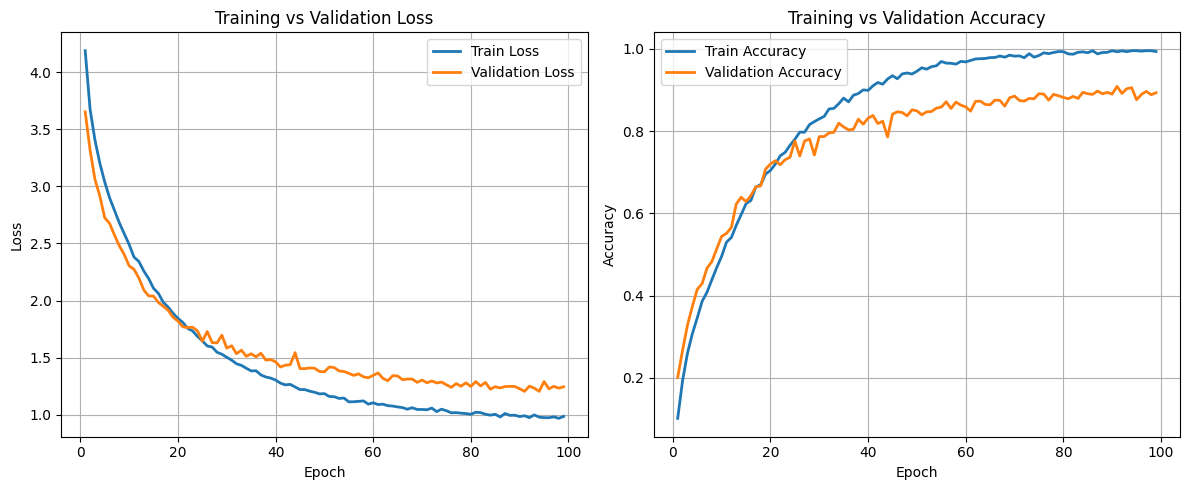

In [92]:
plot_training_curves(train_losses_lightrescnn, val_losses_lightrescnn, train_accs_lightrescnn, val_accs_lightrescnn)

Test Accuracy (Top-1): 0.9097
Test Accuracy (Top-5): 0.9764
Average inference time: 0.05 ms / sample
Number of model parameters: 5,441,126
Model size: 20.81 MB

Macro averages:
Precision: 0.9126
Recall:    0.9082
F1-score:  0.9025
Micro averages:
Precision: 0.9097
Recall:    0.9097
F1-score:  0.9097

Classification Report:
              precision    recall  f1-score   support

         C_0       1.00      0.83      0.91         6
         C_1       1.00      0.89      0.94         9
         C_2       0.60      0.50      0.55         6
         C_3       0.38      0.38      0.38         8
         C_4       0.90      1.00      0.95         9
         C_5       1.00      0.83      0.91         6
         C_6       0.86      1.00      0.92         6
         C_7       0.93      1.00      0.96        13
         C_8       0.60      0.86      0.71         7
         C_9       1.00      1.00      1.00         6
        C_10       0.75      0.92      0.83        13
        C_11       0.93   

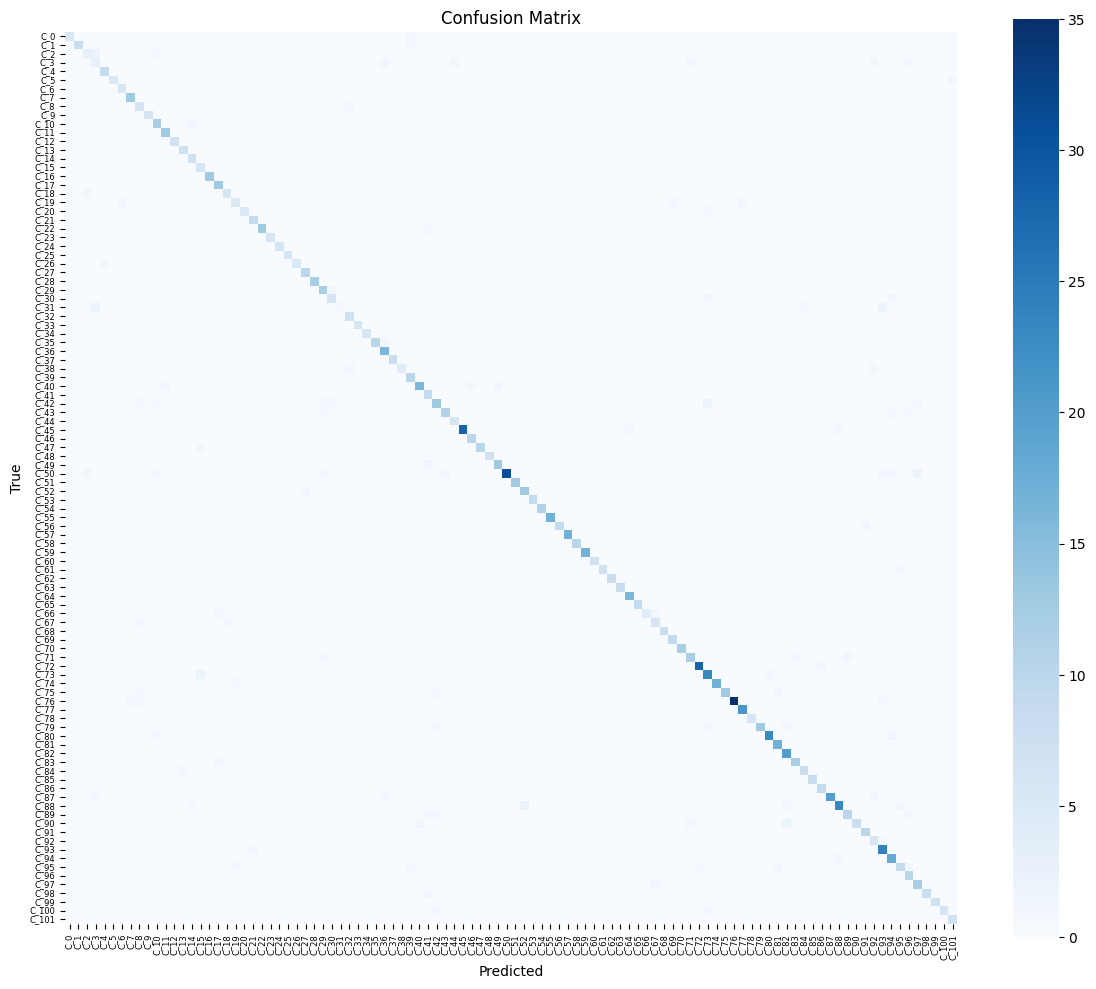

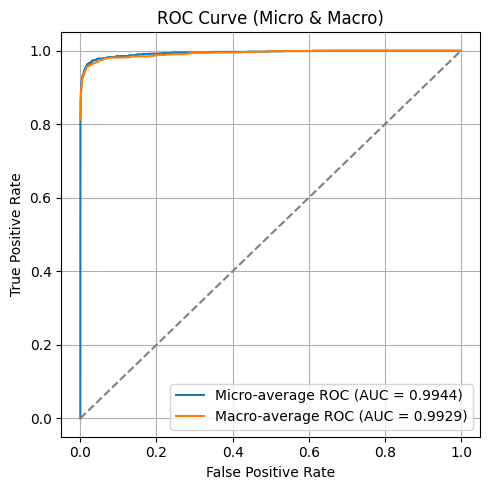

In [93]:
accuracy_lightrescnn, topk_acc_lightrescnn, avg_inf_time_lightrescnn, precision_macro_lightrescnn, recall_macro_lightrescnn, f1_macro_lightrescnn, precision_micro_lightrescnn, recall_micro_lightrescnn, f1_micro_lightrescnn, cm = test_model(
    model=model,
    test_loader=test_loader,
    device=device,
    class_names=[f"C_{i}" for i in range(102)],
    model_path="best_lightrescnn.pth",
    topk=True,
    k=5,
    plots=True,
    plot_numbers=False,
    raport=True
)

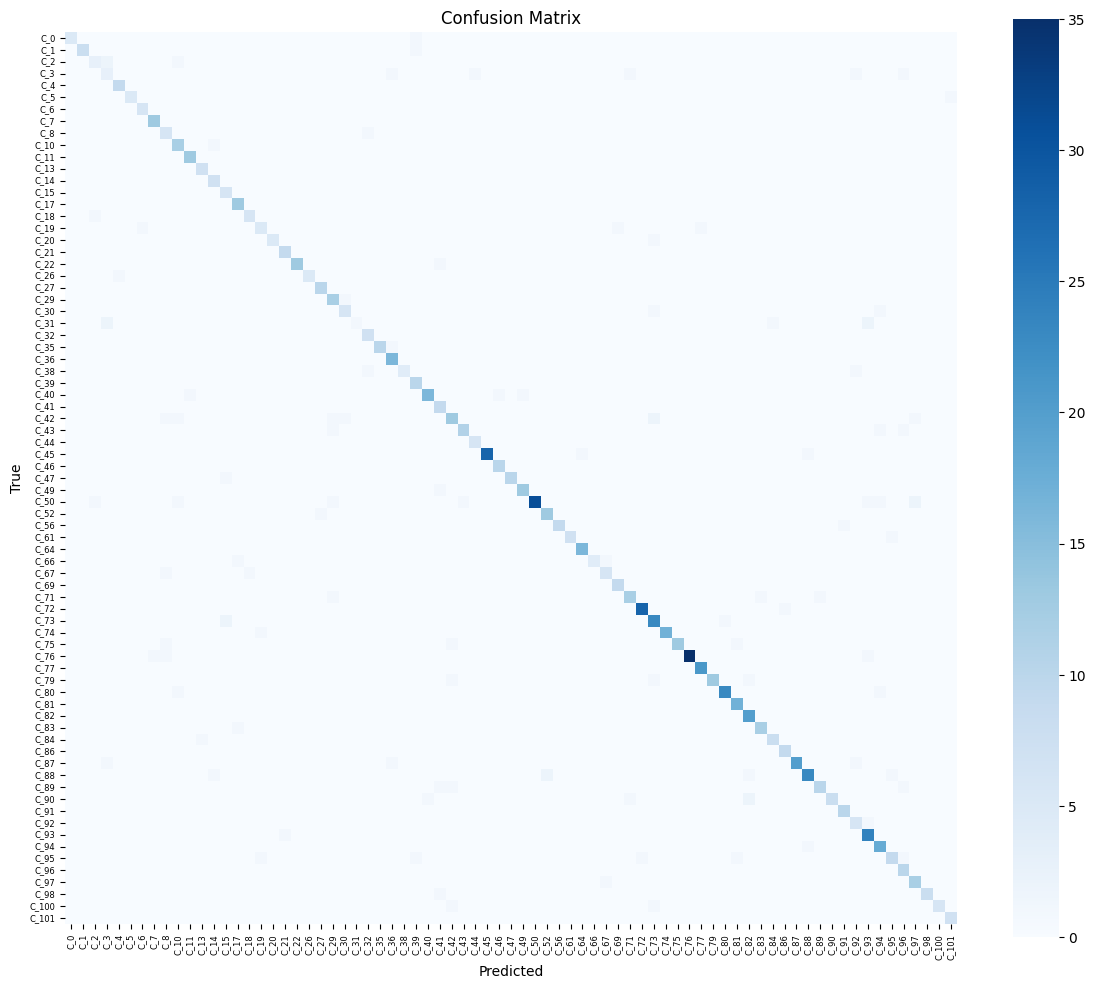

In [91]:
plot_confusion_only_errors(cm, [f"C_{i}" for i in range(102)], plot_numbers=False)


===== CROSS VALIDATION START (10 folds) for LightResCNN =====

--- FOLD 1 Results ---


Training complete in 4723.322332859039 seconds (78.7220 minutes)
Best model from epoch 98: Train Loss: 0.9864 | Train Acc: 0.9930 | Valid Loss: 1.1863 | Valid Acc: 0.9145
Test Accuracy (Top-1): 0.9113
Test Accuracy (Top-5): 0.9788
Average inference time: 0.09 ms / sample
Macro averages:
Precision: 0.9106
Recall:    0.9027
F1-score:  0.9017
Micro averages:
Precision: 0.9113
Recall:    0.9113
F1-score:  0.9113

--- FOLD 2 Results ---


Training interrupted in epoch 95. No improvement for 8 epochs.
Training complete in 5494.400289773941 seconds (91.5733 minutes)
Best model from epoch 87: Train Loss: 0.9834 | Train Acc: 0.9965 | Valid Loss: 1.2120 | Valid Acc: 0.9096
Test Accuracy (Top-1): 0.9162
Test Accuracy (Top-5): 0.9772
Average inference time: 0.08 ms / sample
Macro averages:
Precision: 0.9198
Recall:    0.9067
F1-score:  0.9073
Micro averages:
Precision: 0.9162
Recall:    0.9162
F1-score:  0.9162

--- FOLD 3 Results ---


Training interrupted in epoch 76. No improvement for 8 epochs.
Training complete in 5161.12557387352 seconds (86.0188 minutes)
Best model from epoch 68: Train Loss: 1.0395 | Train Acc: 0.9860 | Valid Loss: 1.2761 | Valid Acc: 0.8852
Test Accuracy (Top-1): 0.8861
Test Accuracy (Top-5): 0.9748
Average inference time: 0.09 ms / sample
Macro averages:
Precision: 0.8900
Recall:    0.8742
F1-score:  0.8721
Micro averages:
Precision: 0.8861
Recall:    0.8861
F1-score:  0.8861

--- FOLD 4 Results ---


Training interrupted in epoch 93. No improvement for 8 epochs.
Training complete in 6383.767655134201 seconds (106.3961 minutes)
Best model from epoch 85: Train Loss: 0.9840 | Train Acc: 0.9928 | Valid Loss: 1.2085 | Valid Acc: 0.9080
Test Accuracy (Top-1): 0.9170
Test Accuracy (Top-5): 0.9821
Average inference time: 0.09 ms / sample
Macro averages:
Precision: 0.9220
Recall:    0.9141
F1-score:  0.9120
Micro averages:
Precision: 0.9170
Recall:    0.9170
F1-score:  0.9170

--- FOLD 5 Results ---


Training interrupted in epoch 91. No improvement for 8 epochs.
Training complete in 6087.269074678421 seconds (101.4545 minutes)
Best model from epoch 83: Train Loss: 1.0158 | Train Acc: 0.9899 | Valid Loss: 1.2227 | Valid Acc: 0.9015
Test Accuracy (Top-1): 0.9097
Test Accuracy (Top-5): 0.9845
Average inference time: 0.09 ms / sample
Macro averages:
Precision: 0.9133
Recall:    0.8934
F1-score:  0.8973
Micro averages:
Precision: 0.9097
Recall:    0.9097
F1-score:  0.9097

--- FOLD 6 Results ---


Training interrupted in epoch 76. No improvement for 8 epochs.
Training complete in 4997.405596971512 seconds (83.2901 minutes)
Best model from epoch 68: Train Loss: 1.0342 | Train Acc: 0.9874 | Valid Loss: 1.2572 | Valid Acc: 0.8852
Test Accuracy (Top-1): 0.8893
Test Accuracy (Top-5): 0.9707
Average inference time: 0.10 ms / sample
Macro averages:
Precision: 0.8929
Recall:    0.8758
F1-score:  0.8748
Micro averages:
Precision: 0.8893
Recall:    0.8893
F1-score:  0.8893

--- FOLD 7 Results ---


Training interrupted in epoch 72. No improvement for 8 epochs.
Training complete in 4740.375380039215 seconds (79.0063 minutes)
Best model from epoch 64: Train Loss: 1.0689 | Train Acc: 0.9792 | Valid Loss: 1.2282 | Valid Acc: 0.9137
Test Accuracy (Top-1): 0.8845
Test Accuracy (Top-5): 0.9764
Average inference time: 0.09 ms / sample
Macro averages:
Precision: 0.8882
Recall:    0.8716
F1-score:  0.8720
Micro averages:
Precision: 0.8845
Recall:    0.8845
F1-score:  0.8845

--- FOLD 8 Results ---


Training interrupted in epoch 85. No improvement for 8 epochs.
Training complete in 5440.6659071445465 seconds (90.6778 minutes)
Best model from epoch 77: Train Loss: 1.0183 | Train Acc: 0.9862 | Valid Loss: 1.1934 | Valid Acc: 0.9137
Test Accuracy (Top-1): 0.9072
Test Accuracy (Top-5): 0.9772
Average inference time: 0.09 ms / sample
Macro averages:
Precision: 0.9069
Recall:    0.8979
F1-score:  0.8977
Micro averages:
Precision: 0.9072
Recall:    0.9072
F1-score:  0.9072

--- FOLD 9 Results ---


Training complete in 6341.007207155228 seconds (105.6835 minutes)
Best model from epoch 98: Train Loss: 0.9731 | Train Acc: 0.9953 | Valid Loss: 1.1558 | Valid Acc: 0.9235
Test Accuracy (Top-1): 0.8910
Test Accuracy (Top-5): 0.9764
Average inference time: 0.09 ms / sample
Macro averages:
Precision: 0.8981
Recall:    0.8686
F1-score:  0.8746
Micro averages:
Precision: 0.8910
Recall:    0.8910
F1-score:  0.8910

--- FOLD 10 Results ---


Training interrupted in epoch 94. No improvement for 8 epochs.
Training complete in 6023.382033824921 seconds (100.3897 minutes)
Best model from epoch 86: Train Loss: 0.9895 | Train Acc: 0.9932 | Valid Loss: 1.2221 | Valid Acc: 0.9055
Test Accuracy (Top-1): 0.8942
Test Accuracy (Top-5): 0.9723
Average inference time: 0.09 ms / sample
Macro averages:
Precision: 0.9004
Recall:    0.8816
F1-score:  0.8805
Micro averages:
Precision: 0.8942
Recall:    0.8942
F1-score:  0.8942



===== CROSS-VALIDATION METRICS SUMMARY =====
Mean Top-1 Accuracy: 0.9007 +/- 0.0122
Mean Top-5 Accuracy: 0.9771 +/- 0.0039
Mean Train Time: 5539.27 seconds (92.32 minutes)
Mean Inference Time: 0.09 milliseconds/sample

Macro Averages:
Precision (Macro): 0.9042
Recall    (Macro): 0.8887
F1-Score  (Macro): 0.8890

Micro Averages:
Precision (Micro): 0.9007
Recall    (Micro): 0.9007
F1-Score  (Micro): 0.9007


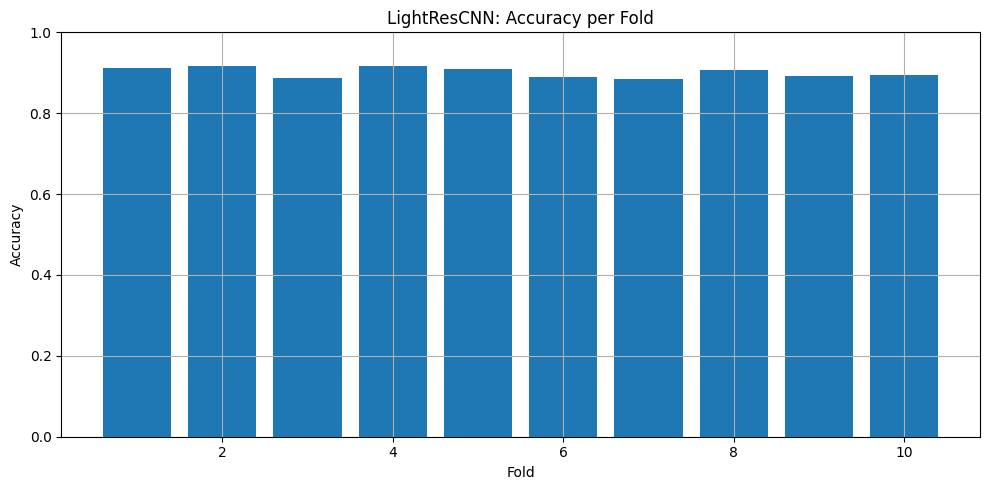

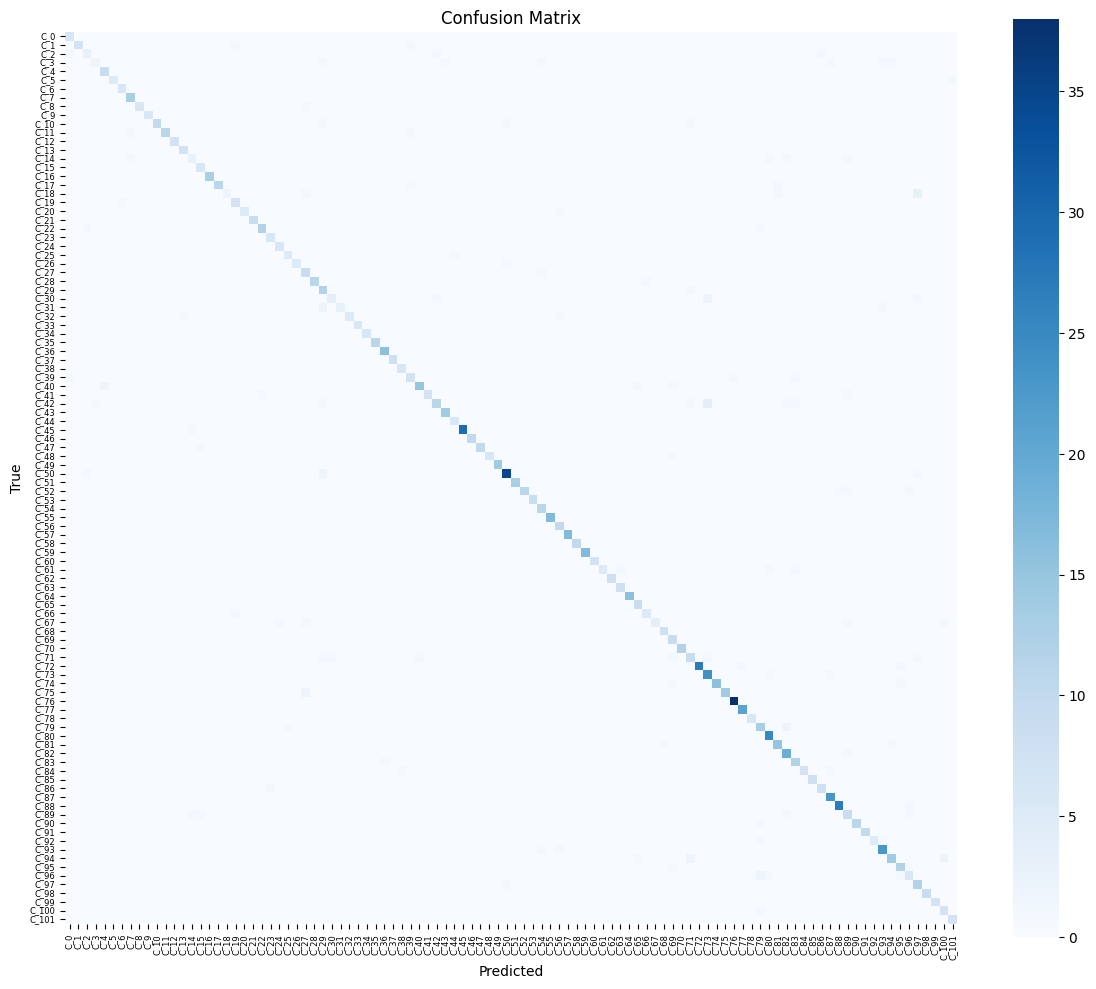

In [15]:
total_cm = cross_validation(
    image_paths=image_paths,
    labels=labels,
    model_name="LightResCNN",
    model_class=lambda: LightResCNN(num_classes=102),
    class_names=[f"C_{i}" for i in range(102)], 
    criterion_fn=lambda: nn.CrossEntropyLoss(label_smoothing=0.1),
    optimizer_fn=lambda model: torch.optim.Adam(model.parameters(), lr=0.0001),
    device=device,
    transform_train=transform_train,
    transform_eval=transform_eval,
    kfold=10,
    batch_size=32,
    num_epochs=100,
    patience=8,
    topk=True,
    k=5,
    scheduler_fn=None,
    plot_numbers=False
    )

Results and Conclusions:

LightResCNN achieved solid performance on the Oxford Flowers 102 dataset while significantly reducing model size and inference cost compared to ResNet-50.

Single split evaluation:
- Top-1 accuracy: 90.97%
- Top-5 accuracy: 97.64%
- Macro F1-score: 90.25%
- Micro F1-score: 90.97%
- Inference time: ~0.05 ms per image
- Model size: 20.81 MB (~5.44M parameters)

Training converged stably, but a noticeable gap between training and validation accuracy indicates limited generalization compared to pretrained ResNet-50. Early stopping selected the best model at epoch 91.

The confusion matrix remains mostly diagonal, but misclassifications are more frequent, especially for visually similar classes and minority categories.

ROC analysis shows high discriminative ability:
- Micro AUC: ~0.994
- Macro AUC: ~0.993

Repeated stratified evaluation (10 runs):
- Mean Top-1 accuracy: 90.07% std 1.22%
- Mean Top-5 accuracy: 97.71% std 0.39%
- Macro F1-score (mean): 88.90%
- Micro F1-score (mean): 90.07%
- Mean inference time: ~0.09 ms per image

Performance variance across runs is moderate, indicating higher sensitivity to data splits compared to ResNet-50.

Overall, LightResCNN offers a strong accuracy-efficiency trade-off and may be a practical choice for resource-constrained environments, though it does not match the performance of deep pretrained architectures in fine-grained classification tasks.

=------------------------------------- ResNet-50 FC Pretrained and From Scratch -------------------------------------=

In this section I compare two alternative training strategies to quantify the impact of transfer learning:

Pretrained ResNet-50 + last-layer training only
   - 'pretrained=True', 'fine_tune=False'
   - The ResNet backbone is frozen and only the final 'fc' layer is trained

ResNet-50 trained from scratch
   - 'pretrained=False', 'fine_tune=True'
   - All parameters are trained with random initialization

Both variants use the same loss function (Cross-Entropy with label smoothing) and optimizer settings to ensure a fair comparison.

In [71]:
print("Last layer tune pretrained\n")

model = resnet50_model(num_classes=102, fine_tune=False, pretrained=True).to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.0001)

model, total_time_fc_pretrained, train_losses_fc_pretrained, val_losses_fc_pretrained, train_accs_fc_pretrained, val_accs_fc_pretrained = train_model(
    model=model,
    train_loader=train_pretrained_loader,
    val_loader=val_pretrained_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=100,
    patience=8,
    save_path="best_resnet50_fc_pretrained.pth",
    scheduler=None,
    logs=False
)

accuracy_fc_pretrained, topk_acc_fc_pretrained, avg_inf_time_fc_pretrained, precision_macro_fc_pretrained, recall_macro_fc_pretrained, f1_macro_fc_pretrained, precision_micro_fc_pretrained, recall_micro_fc_pretrained, f1_micro_fc_pretrained, cm = test_model(
    model=model,
    test_loader=test_pretrained_loader,
    device=device,
    class_names=[f"C_{i}" for i in range(102)],
    model_path="best_resnet50_fc_pretrained.pth",
    topk=True,
    k=5,
    plots=False,
    plot_numbers=False,
    raport=False
)

print("\nFull tune scratch\n")

model = resnet50_model(num_classes=102, fine_tune=True, pretrained=False).to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

model, total_time_full_scratch, train_losses_full_scratch, val_losses_full_scratch, train_accs_full_scratch, val_accs_full_scratch = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=100,
    patience=8,
    save_path="best_resnet50_full_scratch.pth",
    scheduler=None,
    logs=False
)

accuracy_full_scratch, topk_acc_full_scratch, avg_inf_time_full_scratch, precision_macro_full_scratch, recall_macro_full_scratch, f1_macro_full_scratch, precision_micro_full_scratch, recall_micro_full_scratch, f1_micro_full_scratch, cm = test_model(
    model=model,
    test_loader=test_loader,
    device=device,
    class_names=[f"C_{i}" for i in range(102)],
    model_path="best_resnet50_full_scratch.pth",
    topk=True,
    k=5,
    plots=False,
    plot_numbers=False,
    raport=False
)

Last layer tune pretrained



Training complete in 5719.463896989822 seconds (95.3244 minutes)
Best model from epoch 93: Train Loss: 1.0596 | Train Acc: 0.9773 | Valid Loss: 1.2116 | Valid Acc: 0.9283
Test Accuracy (Top-1): 0.9170
Test Accuracy (Top-5): 0.9813
Average inference time: 0.28 ms / sample
Macro averages:
Precision: 0.9224
Recall:    0.9100
F1-score:  0.9124
Micro averages:
Precision: 0.9170
Recall:    0.9170
F1-score:  0.9170

Full tune scratch



Training interrupted in epoch 34. No improvement for 8 epochs.
Training complete in 2657.4823422431946 seconds (44.2914 minutes)
Best model from epoch 26: Train Loss: 1.2355 | Train Acc: 0.9025 | Valid Loss: 1.5913 | Valid Acc: 0.7834
Test Accuracy (Top-1): 0.7624
Test Accuracy (Top-5): 0.9341
Average inference time: 0.28 ms / sample
Macro averages:
Precision: 0.7895
Recall:    0.7552
F1-score:  0.7539
Micro averages:
Precision: 0.7624
Recall:    0.7624
F1-score:  0.7624


Results and Conclusions:

This ablation study compares different ResNet-50 training strategies to isolate the impact of transfer learning.

Pretrained ResNet-50 - last-layer fine-tuning only (frozen backbone):
- Top-1 accuracy: 91.70%
- Top-5 accuracy: 98.13%
- Macro F1-score: 91.24%
- Micro F1-score: 91.70%
- Inference time: ~0.28 ms per image

Training only the final classification layer on top of frozen pretrained features achieves reasonable performance with limited risk of overfitting. However, the lack of feature adaptation to the Flowers 102 domain constrains the final accuracy.

ResNet-50 trained from scratch (no pretrained weights):
- Top-1 accuracy: 76.24%
- Top-5 accuracy: 93.41%
- Macro F1-score: 75.39%
- Micro F1-score: 76.24%
- Inference time: ~0.28 ms per image

Training ResNet-50 from random initialization leads to significantly lower performance. The model struggles to learn both low-level visual features and fine-grained class discriminative patterns from a relatively small dataset.

These results clearly demonstrate that pretrained features are critical for achieving high accuracy on fine-grained classification tasks. Full fine-tuning provides the best performance, while freezing the backbone offers a computationally cheaper but less accurate alternative. Training from scratch is not competitive in this setting.

=------------------------------------- Summary -------------------------------------=

In this section I perform a unified comparison of all evaluated models and training strategies.

The analysis includes:
- comparison of training and validation loss curves,
- comparison of training and validation accuracy curves,
- a consolidated results table summarizing final performance metrics.

The following models are compared:
- ResNet-50 with pretrained weights and full fine-tuning,
- ResNet-50 with pretrained weights and frozen backbone (FC-only training),
- ResNet-50 trained from scratch,
- the proposed lightweight LightResCNN model.

All models are evaluated using the same dataset splits, loss function and metrics, allowing for a fair and consistent comparison of convergence behavior and final performance.

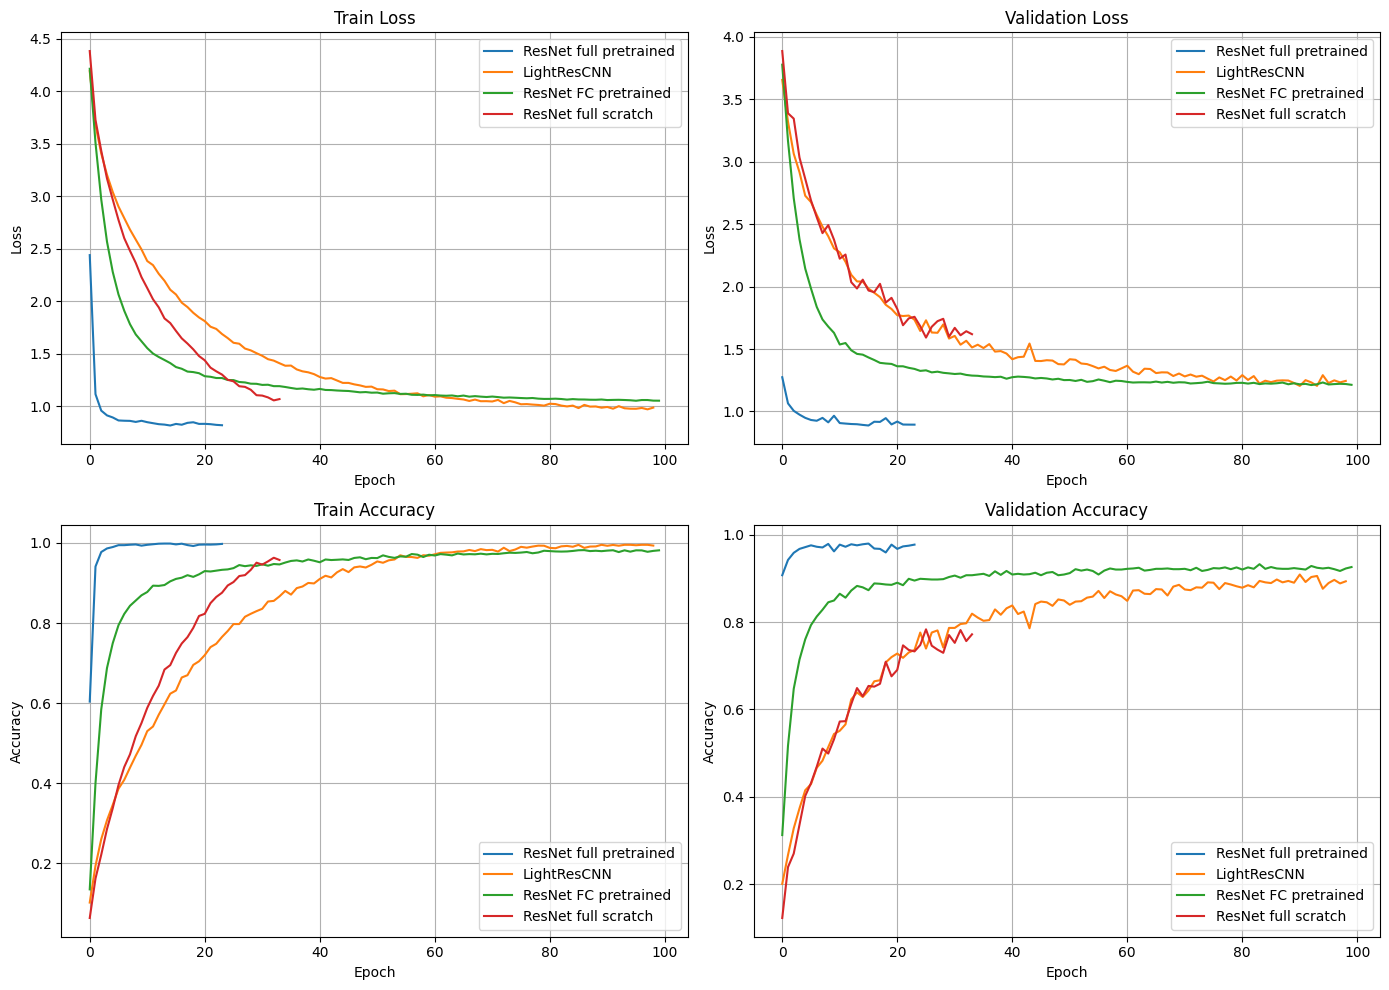

,Model,Accuracy,Avg Inf Time,TopK Accuracy,F1 Micro,F1 Macro,Train Time
0,ResNet full pretrained,0.971522,0.000126,0.995932,0.971522,0.968512,1057.300946
1,LightResCNN,0.909683,0.000054,0.976404,0.909683,0.902529,6104.298894
2,ResNet FC pretrained,0.917006,0.000275,0.981286,0.917006,0.912377,5719.463897
3,ResNet full scratch,0.762408,0.000285,0.934093,0.762408,0.753928,2657.482342


In [ ]:
plt.figure(figsize=(14,10))

plt.subplot(2,2,1)
plt.plot(train_losses_full_pretrained, label="ResNet full pretrained")
plt.plot(train_losses_lightrescnn, label="LightResCNN")
plt.plot(train_losses_fc_pretrained, label="ResNet FC pretrained")
plt.plot(train_losses_full_scratch, label="ResNet full scratch")
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(2,2,2)
plt.plot(val_losses_full_pretrained, label="ResNet full pretrained")
plt.plot(val_losses_lightrescnn, label="LightResCNN")
plt.plot(val_losses_fc_pretrained, label="ResNet FC pretrained")
plt.plot(val_losses_full_scratch, label="ResNet full scratch")
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(2,2,3)
plt.plot(train_accs_full_pretrained, label="ResNet full pretrained")
plt.plot(train_accs_lightrescnn, label="LightResCNN")
plt.plot(train_accs_fc_pretrained, label="ResNet FC pretrained")
plt.plot(train_accs_full_scratch, label="ResNet full scratch")
plt.title("Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(2,2,4)
plt.plot(val_accs_full_pretrained, label="ResNet full pretrained")
plt.plot(val_accs_lightrescnn, label="LightResCNN")
plt.plot(val_accs_fc_pretrained, label="ResNet FC pretrained")
plt.plot(val_accs_full_scratch, label="ResNet full scratch")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

import pandas as pd
results_df = pd.DataFrame([
    ["ResNet full pretrained", accuracy_full_pretrained, avg_inf_time_full_pretrained,
     topk_acc_full_pretrained, f1_micro_full_pretrained, f1_macro_full_pretrained,
     total_time_full_pretrained],

    ["LightResCNN", accuracy_lightrescnn, avg_inf_time_lightrescnn,
     topk_acc_lightrescnn, f1_micro_lightrescnn, f1_macro_lightrescnn,
     total_time_lightrescnn],

    ["ResNet FC pretrained", accuracy_fc_pretrained, avg_inf_time_fc_pretrained,
     topk_acc_fc_pretrained, f1_micro_fc_pretrained, f1_macro_fc_pretrained,
     total_time_fc_pretrained],

    ["ResNet full scratch", accuracy_full_scratch, avg_inf_time_full_scratch,
     topk_acc_full_scratch, f1_micro_full_scratch, f1_macro_full_scratch,
     total_time_full_scratch],
], columns=["Model", "Accuracy", "Avg Inf Time", "TopK Accuracy", "F1 Micro", "F1 Macro", "Train Time"])

results_df

Final Results and Conclusions:

The comparison highlights clear differences in convergence behavior, final accuracy and computational efficiency across the evaluated models.

ResNet-50 with pretrained weights and full fine-tuning achieves the best overall results. It converges very quickly, reaching high validation accuracy within the first few epochs, and maintains a small gap between training and validation curves. This indicates strong generalization and effective adaptation of pretrained features to the target dataset.

LightResCNN converges more slowly and exhibits a noticeable train-validation gap. Although it achieves reasonable accuracy, its limited capacity restricts performance on fine-grained classes. The model trades accuracy for efficiency, offering the fastest inference time and the smallest model size.

ResNet-50 with a frozen pretrained backbone (FC-only training) converges smoothly but saturates early. While pretrained features provide a strong starting point, the lack of feature-level adaptation limits final performance compared to full fine-tuning.

ResNet-50 trained from scratch shows the weakest performance. Both loss and accuracy curves indicate slower convergence and poorer generalization. This confirms that the dataset size is insufficient for training deep architectures from random initialization.

Overall ranking (accuracy):  
1st ResNet-50 full pretrained  
2nd ResNet-50 FC pretrained  
3rd LightResCNN  
4th ResNet-50 full scratch  